In [1]:
# Copyright 2025 Bytedance Ltd. and/or its affiliates.
# SPDX-License-Identifier: Apache-2.0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

/users/zyy/miniconda3/envs/bagel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Initialization

In [4]:
model_path = "/users/zyy/data/work_dir/BAGEL-7B-MoT"  # Download from https://huggingface.co/ByteDance-Seed/BAGEL-7B-MoT

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading
vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64,
)

with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing
tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

## Model Loading and Multi GPU Infernece Preparing

In [5]:
max_mem_per_gpu = "15GiB"  # Modify it according to your GPU setting. On an A100, 80 GiB is sufficient to load on a single GPU.

device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(torch.cuda.device_count())},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
)
print(device_map)

same_device_modules = [
    'language_model.model.embed_tokens',
    'time_embedder',
    'latent_pos_embed',
    'vae2llm',
    'llm2vae',
    'connector',
    'vit_pos_embed'
]

if torch.cuda.device_count() == 1:
    first_device = device_map.get(same_device_modules[0], "cuda:0")
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device
        else:
            device_map[k] = "cuda:0"
else:
    first_device = device_map.get(same_device_modules[0])
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device

# Thanks @onion-liu: https://github.com/ByteDance-Seed/Bagel/pull/8
model = load_checkpoint_and_dispatch(
    model,
    checkpoint=os.path.join(model_path, "ema.safetensors"),
    device_map=device_map,
    offload_buffers=True,
    dtype=torch.bfloat16,
    force_hooks=True,
    offload_folder="/tmp/offload"
)

model = model.eval()
print('Model loaded')

The safetensors archive passed at /users/zyy/data/work_dir/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


OrderedDict([('language_model.model.embed_tokens', 0), ('language_model.model.layers.0', 0), ('language_model.model.layers.1', 0), ('language_model.model.layers.2', 0), ('language_model.model.layers.3', 0), ('language_model.model.layers.4', 0), ('language_model.model.layers.5', 0), ('language_model.model.layers.6', 0), ('language_model.model.layers.7', 0), ('language_model.model.layers.8', 0), ('language_model.model.layers.9', 0), ('language_model.model.layers.10', 0), ('language_model.model.layers.11', 0), ('language_model.model.layers.12', 0), ('language_model.model.layers.13', 0), ('language_model.model.layers.14', 0), ('language_model.model.layers.15', 0), ('language_model.model.layers.16', 0), ('language_model.model.layers.17', 0), ('language_model.model.layers.18', 0), ('language_model.model.layers.19', 0), ('language_model.model.layers.20', 1), ('language_model.model.layers.21', 1), ('language_model.model.layers.22', 1), ('language_model.model.layers.23', 1), ('language_model.mo

Model loaded


## Inferencer Preparing 

In [6]:
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

In [7]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**About Inference Hyperparameters:**
- **`cfg_text_scale`:** Controls how strongly the model follows the text prompt. `1.0` disables text guidance. Typical range: `4.0–8.0`.
- **`cfg_image_scale`:** Controls how much the model preserves input image details. `1.0` disables image guidance. Typical range: `1.0–2.0`.
- **`cfg_interval`:** Fraction of denoising steps where CFG is applied. Later steps can skip CFG to reduce computation. Typical: `[0.4, 1.0]`.
- **`timestep_shift`:** Shifts the distribution of denoising steps. Higher values allocate more steps at the start (affects layout); lower values allocate more at the end (improves details).
- **`num_timesteps`:** Total denoising steps. Typical: `50`.
- **`cfg_renorm_min`:** Minimum value for CFG-Renorm. `1.0` disables renorm. Typical: `0`.
- **`cfg_renorm_type`:** CFG-Renorm method:  
  - `global`: Normalize over all tokens and channels (default for T2I).
  - `channel`: Normalize across channels for each token.
  - `text_channel`: Like `channel`, but only applies to text condition (good for editing, may cause blur).
- **If edited images appear blurry, try `global` CFG-Renorm, decrease `cfg_renorm_min` or decrease `cfg_scale`.**


## Image Generation

In [8]:
# inference_hyper=dict(
#     cfg_text_scale=4.0,
#     cfg_img_scale=1.0,
#     cfg_interval=[0.4, 1.0],
#     timestep_shift=3.0,
#     num_timesteps=50,
#     cfg_renorm_min=0.0,
#     cfg_renorm_type="global",
# )

A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere.
----------


100%|██████████| 49/49 [01:03<00:00,  1.29s/it]


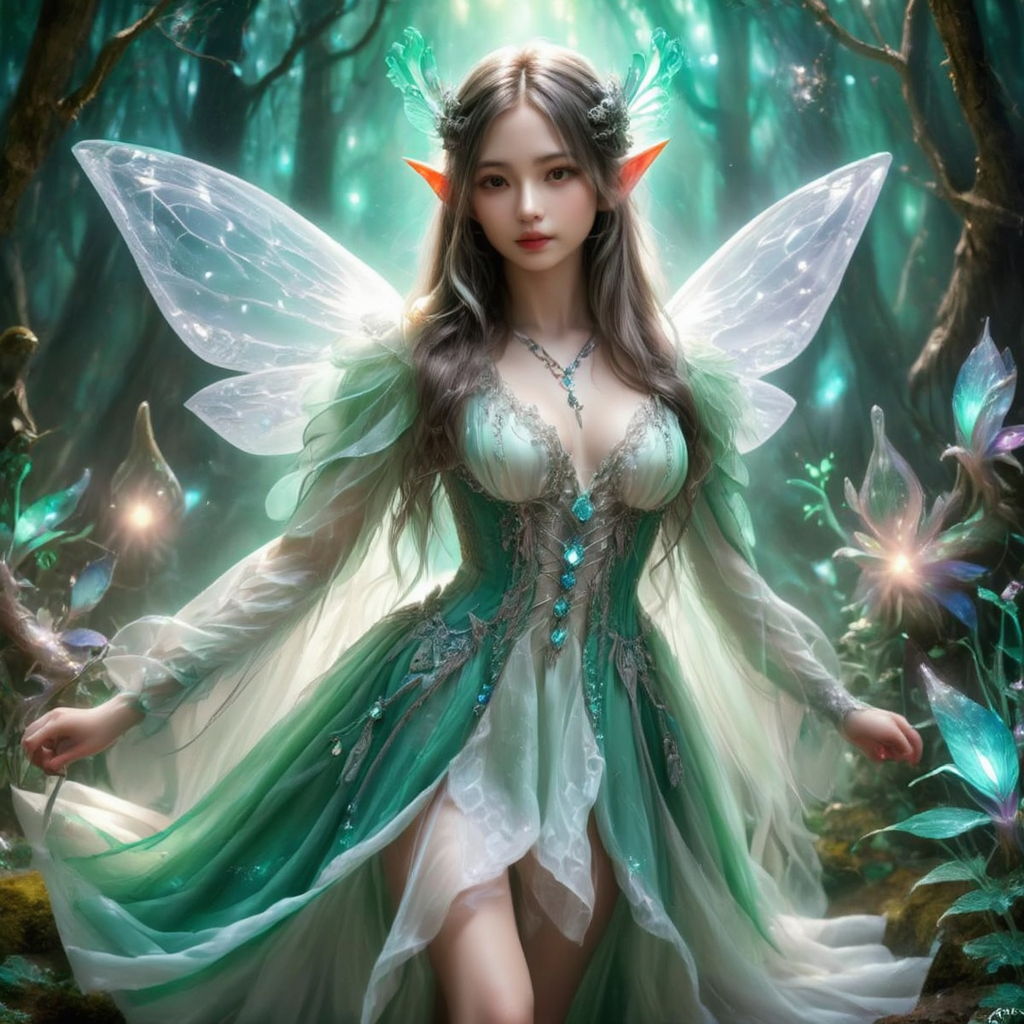

In [9]:
# prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."

# print(prompt)
# print('-' * 10)
# output_dict = inferencer(text=prompt, **inference_hyper)
# display(output_dict['image'])

## Image Generation with Think

In [10]:
# inference_hyper=dict(
#     max_think_token_n=1000,
#     do_sample=False,
#     # text_temperature=0.3,
#     cfg_text_scale=4.0,
#     cfg_img_scale=1.0,
#     cfg_interval=[0.4, 1.0],
#     timestep_shift=3.0,
#     num_timesteps=50,
#     cfg_renorm_min=0.0,
#     cfg_renorm_type="global",
# )

a car made of small cars
----------


100%|██████████| 49/49 [01:03<00:00,  1.30s/it]


<think>
The model should generate an image of a large car composed entirely of smaller cars arranged in a cohesive structure, demonstrating a creative and unconventional design.
Here’s the full, detailed prompt: A massive, intricately designed car composed entirely of smaller cars arranged in a cohesive and artistic structure, showcasing a creative and unconventional design. The smaller cars are tightly packed and organized in a visually striking pattern, with varying shapes, colors, and models creating a dynamic and textured surface. The scene is set in a spacious, well-lit studio with neutral tones, emphasizing the car's unique composition. The lighting is soft and diffused, highlighting the details of the smaller cars and the overall craftsmanship. The atmosphere is modern and futuristic, with a focus on innovation and artistic expression, captured in ultra-realistic detail with sharp focus and subtle shadows.
</think>


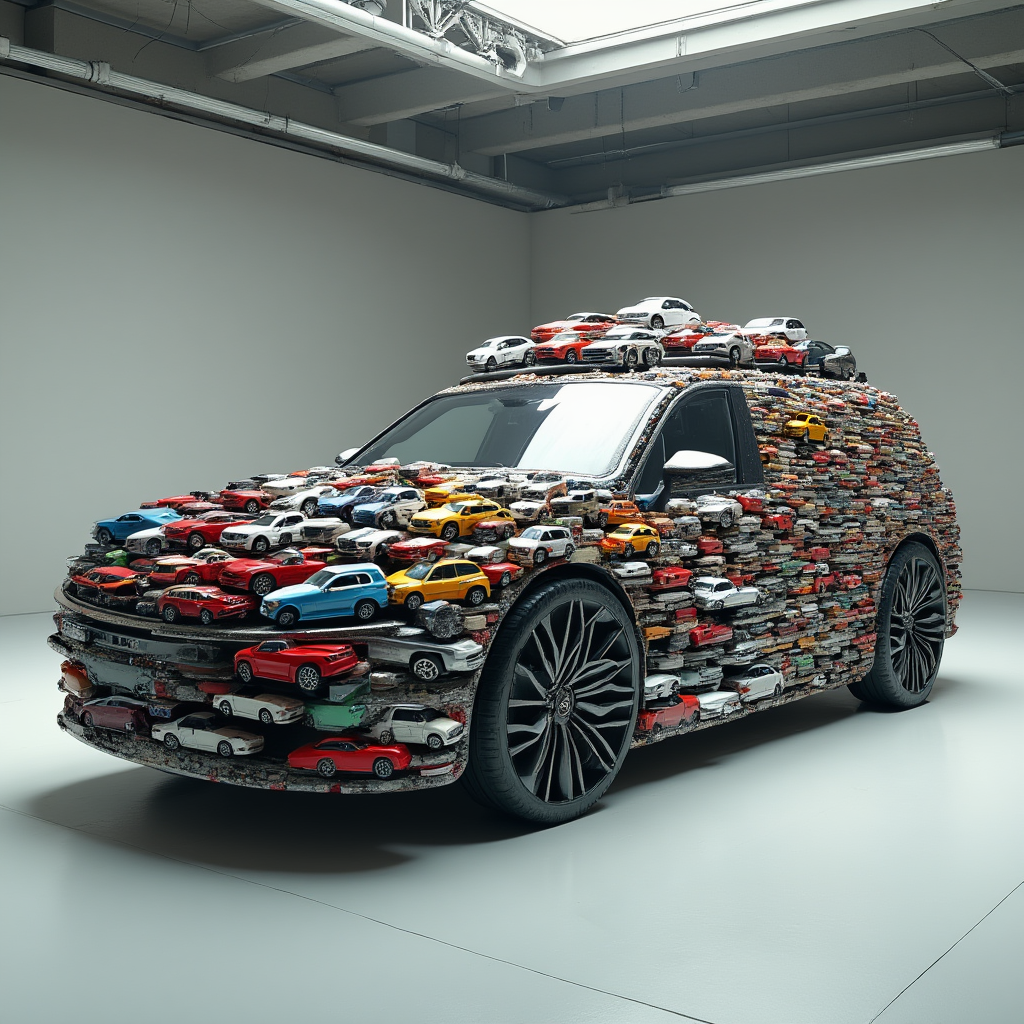

In [11]:
# prompt = 'a car made of small cars'

# print(prompt)
# print('-' * 10)
# output_dict = inferencer(text=prompt, think=True, **inference_hyper)
# print(output_dict['text'])
# display(output_dict['image'])

## Editing

In [12]:
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

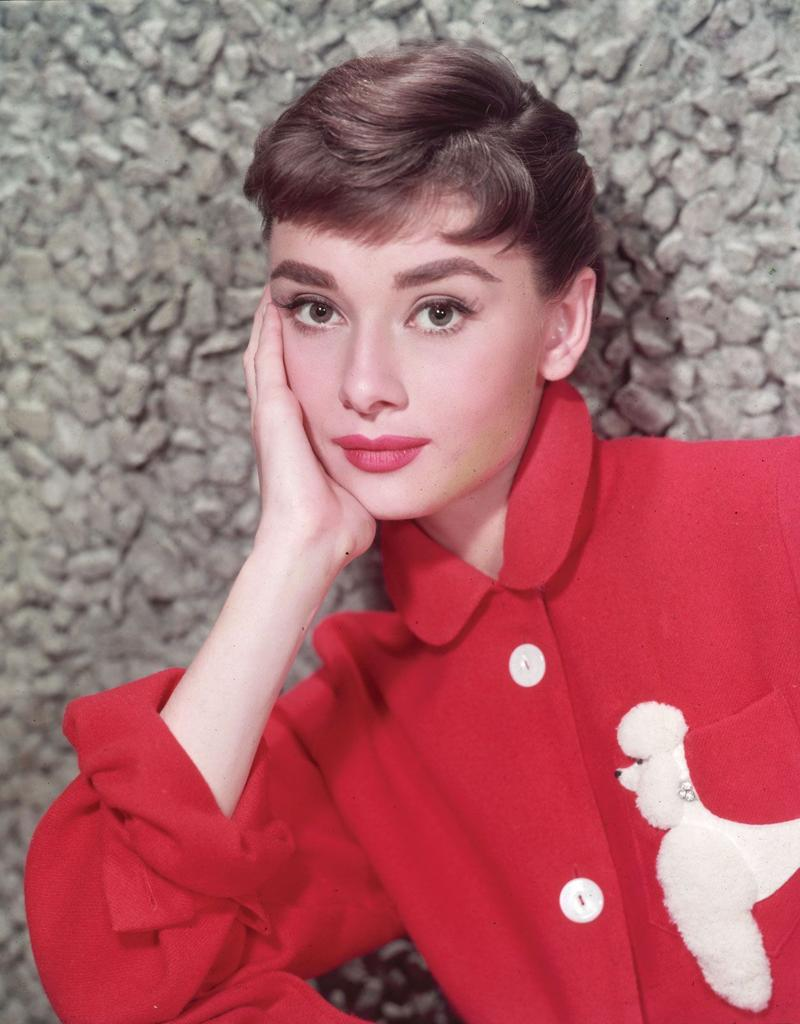

She boards a modern subway, quietly reading a folded newspaper, wearing the same clothes.
----------


100%|██████████| 49/49 [01:36<00:00,  1.98s/it]


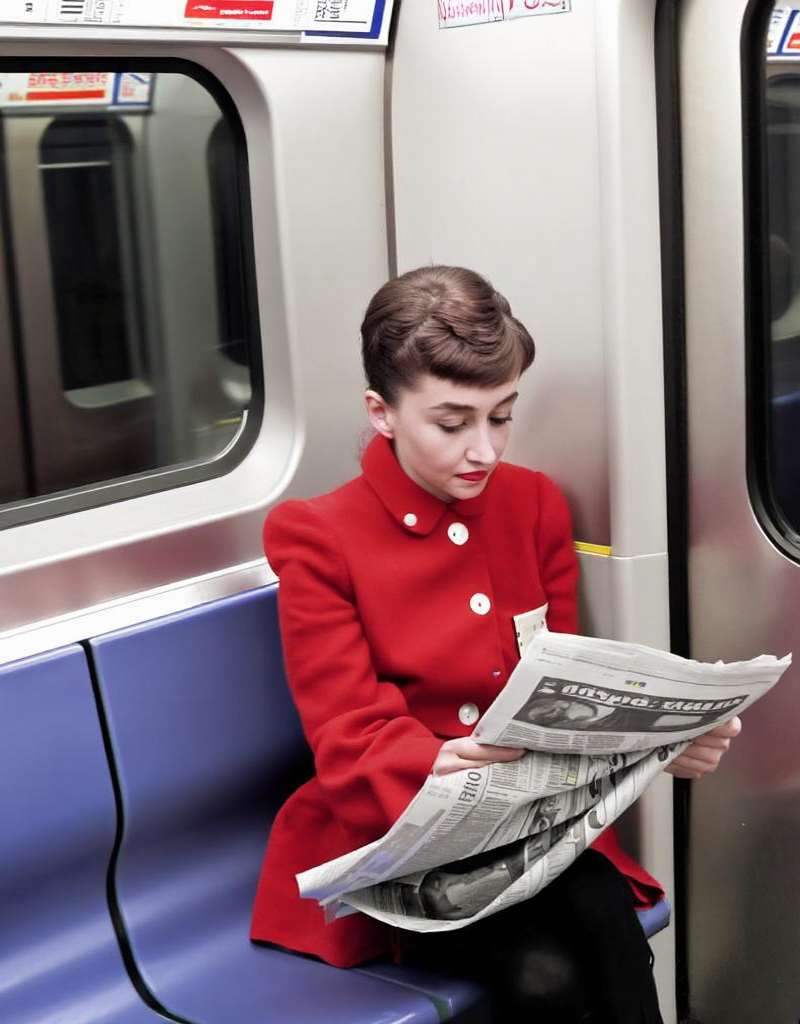

In [13]:
image = Image.open('test_images/women.jpg')
prompt = 'She boards a modern subway, quietly reading a folded newspaper, wearing the same clothes.'

display(image)
print(prompt)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, **inference_hyper)
display(output_dict['image'])

In [19]:
# Cell 2

# 定义配置参数
class Args:
    def __init__(self):
        # 你的输入图片文件夹路径
        self.input_dir = "/users/zyy/autodl-tmp/playground/data/eval/pope/val2014" # <-- 请替换为你的实际路径
        self.output_dir = "/users/zyy/autodl-tmp/playground/data/eval/pope/val2014_bagle" # <-- 请替换为你的实际路径
        self.seed = 1234
        self.size_level = 1024 # BAGEL的inferencer可能不直接使用此参数，需根据模型调整
        self.num_steps = 50 # 如果 BAGEL 的 inferencer 支持，可以保留
        self.cfg_guidance = 7.5 # 如果 BAGEL 的 inferencer 支持，可以保留
        self.quantized = False # 如果模型需要量化参数，保留
        self.offload = False # 如果模型需要 offload 参数，保留
        self.lora = False # 如果模型需要 lora 参数，保留

args = Args()

# BAGEL 模型的推理超参数
# 这是从你的 .ipynb 示例中提取的，用于控制推理过程
inference_hyper = dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3, # 示例中被注释掉，这里也注释掉
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

In [20]:
# Cell 3

# 确保输入目录存在
assert os.path.exists(args.input_dir), f"Input directory {args.input_dir} does not exist."

# 创建输出目录
os.makedirs(args.output_dir, exist_ok=True)
print(f"Output directory created/exists: {args.output_dir}")

# 定义统一提示 (用于图像编辑或生成)
# 如果 BAGEL 倾向于使用英文提示，这是个合适的翻译。
# 根据你的具体任务和 BAGEL 模型的能力调整此提示。
uniform_prompt = "Identify the object in this image, replace it with a different object, keeping the background unchanged."

Output directory created/exists: /users/zyy/autodl-tmp/playground/data/eval/pope/bagle


In [22]:
# Cell 5
import glob
import time
time_list = []
image_paths = glob.glob(os.path.join(args.input_dir, "*.jpg"), recursive=False) + \
              glob.glob(os.path.join(args.input_dir, "*.JPG"), recursive=False)
image_paths.sort() # 确保按文件名顺序处理


for image_path in image_paths:
    image_name = os.path.basename(image_path)
    output_path = os.path.join(args.output_dir, image_name)

    if os.path.exists(output_path):
        print(f"Skipping '{image_name}' as output file already exists at {output_path}")
        continue

    start_time = time.time()


    image = Image.open(image_path)
    output_dict = inferencer(image=image, text=uniform_prompt, think=True, **inference_hyper)
    print(output_dict['text'])
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    time_list.append(time.time() - start_time)

    output_dict['image'].save(
        os.path.join(output_path), lossless=True
    )
print(f'average time for {args.output_dir}: ', sum(time_list[1:]) / len(time_list[1:]))

100%|██████████| 49/49 [00:55<00:00,  1.13s/it]


<think>
The user wants the object in the image, which is a train, to be replaced with a different object while keeping the background unchanged. The train is the central focus, and the background features a mountainous landscape with trees and a clear sky. To fulfill the request, I would replace the train with a horse-drawn carriage, ensuring the lighting, shadows, and perspective match the original scene. The carriage should be positioned similarly to the train, maintaining the same scale and alignment with the surroundings. The background elements, such as the trees and sky, should remain untouched to preserve the original context.
</think>
Time taken: 89.43 seconds


100%|██████████| 49/49 [00:48<00:00,  1.00it/s]


<think>
The user wants the rice on the plate to be replaced with a different object while keeping the rest of the image unchanged. The plate, vegetables, and background should remain consistent. The replacement object should fit naturally into the plate's space, maintaining the overall composition.
</think>
Time taken: 72.14 seconds


100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


<think>
The task involves replacing the goat in the image with a different object while keeping the background unchanged. The background, including the bus, the person, and the ground, should remain consistent. The goat is replaced with a dog, ensuring the proportions and lighting match the original scene for a natural look.
</think>
Time taken: 74.31 seconds


100%|██████████| 49/49 [00:51<00:00,  1.05s/it]


<think>
The user wants the Wii remote in the image to be replaced with a different object while keeping the rest of the scene unchanged. The Wii remote is the focal point in the foreground, and the background features a monitor displaying a game, a wooden table, and a promotional card for "Sam & Max Season One."  

To address the request, I would replace the Wii remote with a similar-sized object that fits naturally into the scene. For example, a toy or a small figurine could be used. The toy should be positioned in the same hand and orientation as the original Wii remote to maintain realism. The background elements, such as the monitor, table, and promotional card, should remain untouched to preserve the context of the image.  

The final image would show the toy in place of the Wii remote, ensuring the lighting and shadows match the original Wii remote's position to maintain consistency. This approach ensures the replacement is seamless and visually coherent with the rest of the scen

100%|██████████| 49/49 [00:55<00:00,  1.13s/it]


<think>
The user wants the bed in the image replaced with a couch while maintaining the rest of the room's layout and background unchanged. The structure, lighting, and decor should remain consistent, ensuring the new couch integrates naturally into the scene.
</think>
Time taken: 79.68 seconds


100%|██████████| 49/49 [00:55<00:00,  1.13s/it]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The pizza is the central focus, so the replacement object should be visually similar in size and shape to maintain the layout. The background, including the table, plates, and drinks, should remain consistent to preserve the original context. The answer image should show the new object seamlessly integrated into the scene.
</think>
Time taken: 84.68 seconds


100%|██████████| 49/49 [00:56<00:00,  1.16s/it]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a buffet setup with various food items, including sandwiches, bread, and condiments. The object to replace appears to be the bread on the upper shelf.  

To fulfill the request, I would replace the bread with a different item, such as a tray of cookies, while maintaining the same shelf layout and background. The new object should fit naturally into the scene, ensuring the lighting and shadows match the existing environment. The final image would show the same buffet setup but with the bread replaced by cookies, keeping the overall composition intact.
</think>
Time taken: 92.81 seconds


100%|██████████| 49/49 [00:56<00:00,  1.14s/it]


<think>
The user wants the horse in the image to be replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the audience, fencing, and setting, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 83.08 seconds


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, so the replacement object should be placed in the same position and orientation to maintain consistency. The background, including the sky, ground, and surrounding elements, should remain unchanged to preserve the original context. The new object should blend naturally with the scene, ensuring it looks realistic in the environment.
</think>
Time taken: 85.92 seconds


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


<think>
The user wants the yellow bus in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the building, trees, and other elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image.
</think>
Time taken: 83.17 seconds


100%|██████████| 49/49 [00:57<00:00,  1.18s/it]


<think>
The task involves replacing the tennis ball in the image with a different object while keeping the background and other elements unchanged. The tennis ball is the focal point in the foreground, and its replacement should be seamlessly integrated into the scene. The background, including the court, players, and surroundings, should remain consistent to maintain the context of the image. The new object should appear natural in the lighting and position relative to the player's hand and the court.
</think>
Time taken: 88.50 seconds


100%|██████████| 49/49 [00:57<00:00,  1.18s/it]


<think>
The user wants the surfboard in the foreground of the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the beach, ocean, and other objects like the umbrella, chairs, and bags, should remain consistent. The surfboard should be swapped with a recognizable object, such as a beach ball, to maintain the context of a beach setting. The new object should fit naturally into the scene without altering the layout or perspective.
</think>
Time taken: 87.78 seconds


100%|██████████| 49/49 [00:52<00:00,  1.07s/it]


<think>
The user wants the food truck in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the trees, people, and other elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective to ensure realism.
</think>
Time taken: 76.73 seconds


100%|██████████| 49/49 [00:52<00:00,  1.06s/it]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object is a television displaying a football game. To fulfill the request, I would replace the television with a different object, such as a framed picture or artwork, while maintaining the same wall and lighting conditions. The rest of the image, including the bathroom fixtures and layout, should remain identical to preserve the original context.
</think>
Time taken: 80.12 seconds


100%|██████████| 49/49 [00:51<00:00,  1.05s/it]


<think>
The user wants the seagull in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the water, boats, and rocky terrain, should remain consistent. The replacement object should blend naturally with the environment, ensuring the scene looks realistic and cohesive.
</think>
Time taken: 75.97 seconds


100%|██████████| 49/49 [00:51<00:00,  1.06s/it]


<think>
The task involves replacing the pizza slice in the image with a different object while keeping the background unchanged. The original image shows a man and a child sitting on a red blanket, with a pizza slice being held between them. The background includes a room with a tiled floor, a door, and some furniture.  

To achieve the desired result, I would replace the pizza slice with a slice of cake. The cake slice should be visually similar in size and shape to the pizza slice, ensuring it fits naturally into the scene. The background elements, such as the blanket, the bottle, and the room's layout, should remain unchanged to maintain consistency.  

The final image would depict the man and child holding a slice of cake instead of pizza, with the rest of the scene remaining the same. This ensures the replacement is seamless and aligns with the original context.
</think>
Time taken: 90.84 seconds


100%|██████████| 49/49 [00:50<00:00,  1.04s/it]


<think>
The user wants the large metal mixing bowl in the image to be replaced with a different object while keeping the rest of the kitchen setup unchanged. The bowl is located on the left side of the image, near the mixer. To achieve this, I would replace the bowl with a smaller, round object, such as a metal pot, ensuring it fits naturally into the scene. The lighting, texture, and surrounding elements like the mixer and kitchen tools should remain consistent to maintain the original context.
</think>
Time taken: 80.53 seconds


100%|██████████| 49/49 [00:57<00:00,  1.17s/it]


<think>
The user wants the beer glass in the image replaced with a different object while keeping the background intact. The beer glass is the focal point, so it should be swapped with a visually distinct object that fits the context. The pizza and TV background remain unchanged, ensuring the scene's overall composition is preserved. The replacement object should be placed in the same position and lighting to maintain realism.
</think>
Time taken: 85.94 seconds


100%|██████████| 49/49 [00:51<00:00,  1.04s/it]


<think>
The user wants the object on the table in the foreground replaced with a different item while keeping the rest of the image unchanged. The table, chairs, and surrounding furniture should remain the same, but the object on the table (which appears to be a black item) should be swapped for a new object, such as a vase. The lighting, perspective, and layout of the room should stay consistent to maintain realism.
</think>
Time taken: 78.81 seconds


100%|██████████| 49/49 [00:51<00:00,  1.05s/it]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the background unchanged. The original image shows a person playing tennis on a court, with a racket in their hand. To fulfill the request, I would replace the tennis racket with a different item, such as a baseball bat, while maintaining the same pose and lighting conditions. The background, including the court, wall, and surrounding environment, should remain identical to ensure consistency.
</think>
Time taken: 80.08 seconds


100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


<think>
The user wants the cat in the image replaced with a different object while keeping the background intact. The chair, table, and room layout should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The answer image shows a cat replaced with a dog, ensuring the dog's size and position align with the original cat's placement.
</think>
Time taken: 90.70 seconds


100%|██████████| 49/49 [00:52<00:00,  1.07s/it]


<think>
The user wants the object in the image, which is a blue couch, to be replaced with a different object while keeping the background unchanged. The couch is attached to a bike trailer, so the replacement object should fit into the same context and be securely fastened to the trailer. 

To achieve this, I would select a suitable object that matches the size and shape of the couch, ensuring it aligns with the trailer's structure. For example, a wooden pallet or a similar flat object could be used. The new object should be securely fastened with straps or ropes to maintain the same setup as the original image. 

The background, including the street, grass, and bike, should remain unchanged to preserve the original scene's context. The final image would show the wooden pallet replacing the couch, with the same bike and trailer setup, ensuring consistency in the environment and attachment method.
</think>
Time taken: 92.78 seconds


100%|██████████| 49/49 [00:51<00:00,  1.06s/it]


<think>
The user wants the object on the desk replaced while keeping the background intact. The object in question is the small potted plant with red flowers. To achieve this, I would replace the plant with a different item, such as a small vase, while maintaining the same placement and lighting conditions. The rest of the desk setup, including the computer, laptop, and other objects, should remain unchanged to preserve the original context and layout.
</think>
Time taken: 80.19 seconds


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


<think>
The user wants the quilt in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the bed, pillows, and surrounding decor, should remain consistent. The replacement object should fit naturally into the space, maintaining the overall aesthetic of the room. The answer image should show the quilt replaced with a new item, such as a blanket or a piece of furniture, ensuring the layout and lighting match the original image.
</think>
Time taken: 85.65 seconds


100%|██████████| 49/49 [00:57<00:00,  1.17s/it]


<think>
The user wants the backpack in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the laptops, cables, and other items, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original backpack.
</think>
Time taken: 83.89 seconds


100%|██████████| 49/49 [00:57<00:00,  1.18s/it]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the rest of the scene unchanged. The teddy bear is located on the orange couch near the center of the image. To achieve this, I would replace the teddy bear with a new object, such as a vase, while ensuring the couch, surrounding furniture, and background elements remain consistent with the original image. The lighting and perspective should also match the original scene to maintain realism.
</think>
Time taken: 88.75 seconds


100%|██████████| 49/49 [00:51<00:00,  1.06s/it]


<think>
The user wants the husky in the image replaced with a dog of a different breed while keeping the background intact. The husky is curled up on a couch, and the background includes a staircase, a lamp, and a hallway. To achieve the desired result, I would replace the husky with a dog of a different breed, such as a golden retriever, ensuring the new dog fits naturally into the scene. The couch, lighting, and background elements should remain unchanged to maintain consistency.
</think>
Time taken: 81.62 seconds


100%|██████████| 49/49 [00:56<00:00,  1.16s/it]


<think>
The user wants the object in the image replaced with a different item while keeping the background intact. The question_image shows a collection of items, including a phone, wallet, keys, and other accessories, placed on a surface with a brown bag in the background. The task involves identifying the object to replace and substituting it with a new item that fits the context.

To approach this, I would first analyze the layout and ensure the new object is placed in a way that maintains the original composition. The replacement object should be visually similar in size and orientation to the original item to preserve the image's balance. For example, if the original object is a phone, the replacement could be a similar-sized device, like a different phone model or a small notebook.

The answer_image would show the same background and arrangement of items, but with the specified object swapped out for the new item. The new item should blend naturally into the scene, ensuring the o

100%|██████████| 49/49 [00:52<00:00,  1.07s/it]


<think>
The user wants the umbrella in the image replaced with a different object while keeping the background unchanged. The umbrella is the central object in the foreground, and its removal requires replacing it with a new item that fits the scene's context. The background, including the deck, railing, and surrounding greenery, should remain untouched. The replacement object should be visually consistent with the setting, such as a potted plant, to maintain the aesthetic harmony of the scene. The final image should show the new object seamlessly integrated into the original composition.
</think>
Time taken: 83.54 seconds


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


<think>
The user wants the cake in the image replaced with a different object while keeping the background and plate design unchanged. The cake is the central focus, so the replacement object should be visually similar in size and placement to maintain the composition. The new object, a slice of pizza, is chosen for its contrasting texture and color while fitting the context of the plate and table setting. The background and plate remain untouched to preserve the original layout.
</think>
Time taken: 86.42 seconds


100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball player in a batting stance, holding a bat. The object to replace is the bat.  

To achieve this, I would replace the bat with a baseball glove, ensuring the player's pose and stance remain consistent. The background, including the chain-link fence, field, and lighting, should remain unchanged to maintain the original context. The new image would depict the player holding a baseball glove instead of a bat, with the same environment intact.
</think>
Time taken: 96.13 seconds


100%|██████████| 49/49 [00:57<00:00,  1.17s/it]


<think>
The user wants the cow in the foreground to be replaced with a different object while keeping the background intact. The background, including the beach, people, and scenery, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the lighting and perspective to ensure consistency.
</think>
Time taken: 83.40 seconds


100%|██████████| 49/49 [00:57<00:00,  1.18s/it]


<think>
The user wants the object in the image, which is a wakeboard, to be replaced with a different object while keeping the background unchanged. The wakeboard is the central focus of the image, and the background features water and splashes. To achieve the desired result, I would replace the wakeboard with a different object, such as a surfboard, while maintaining the same angle, lighting, and water splashes to ensure consistency with the original scene. The final image should depict the person holding onto the surfboard, with the water and splashes remaining intact to preserve the context of the activity.
</think>
Time taken: 91.90 seconds


100%|██████████| 49/49 [00:57<00:00,  1.17s/it]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the background and layout unchanged. The pizza is the central focus, so the replacement object should be placed in the same position and size to maintain consistency. The background, including the people, furniture, and room details, should remain untouched to preserve the original context.
</think>
Time taken: 84.89 seconds


100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


<think>
The user wants the stop sign in the image to be replaced with a different object while keeping the rest of the scene unchanged. The stop sign is the focal point, and the background, including the railway crossing sign, tracks, and surrounding environment, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 67.70 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the motorcycle in the foreground of the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the cars, traffic lights, and urban environment, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 59.04 seconds


100%|██████████| 49/49 [00:39<00:00,  1.26it/s]


<think>
The user wants the object in the foreground of the image to be replaced with a different object while keeping the background unchanged. The original image features a close-up of fruits, including a banana and other items. The task involves identifying the banana and replacing it with a different fruit, such as a mango, while maintaining the same background and layout.

To achieve this, I would focus on preserving the texture, lighting, and perspective of the background to ensure the replacement looks natural. The mango should be positioned similarly to the banana, ensuring it blends seamlessly with the surrounding fruits. The final image would show the mango replacing the banana, with the rest of the fruits and background remaining consistent.
</think>
Time taken: 64.55 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the yellow object in the image to be replaced with a different object while keeping the background unchanged. The yellow object appears to be a ball, and the replacement object should be visually consistent with the context of the scene. 

In the answer image, the yellow ball is replaced with a tennis ball, which is appropriate for the setting, as the person is playing on a court-like surface. The background, including the buildings, fence, and trees, remains unchanged to maintain the original context. This ensures the replacement is seamless and aligns with the user's request.
</think>
Time taken: 53.90 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the green vase in the image to be replaced with a different object while keeping the background and other elements unchanged. The vase is the central object in the image, so it needs to be swapped for something visually distinct yet fitting the context. 

In this case, the replacement object should be a small, decorative item that complements the aesthetic of the scene. A small, colorful bowl is a suitable choice, as it contrasts with the green vase while maintaining the overall simplicity of the setup. The bowl's vibrant color and shape add visual interest without overwhelming the composition.

The background, including the wall and table, should remain the same to preserve the original context. The placement of the bowl should be similar to the vase's position to maintain balance in the image. The final image would show the bowl in place of the vase, ensuring the replacement is seamless and retains the original layout.
</think>
Time taken: 66.69 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball player in a batting stance, with a bat in hand. The object to replace is the bat. 

To achieve this, I would replace the bat with a baseball glove, ensuring the glove is positioned naturally in the player's hand. The background, including the field, catcher, and umpire, should remain unchanged to maintain the context of the scene. The final image would depict the player holding a baseball glove instead of a bat, with all other elements of the scene preserved.
</think>
Time taken: 56.12 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the skier in the air to be replaced with a different object while keeping the rest of the image unchanged. The background, including the snowy slope, spectators, and ski lift, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 59.43 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background unchanged. The bus is the central object in the foreground, and the background includes buildings, a street, and pedestrians. To fulfill the request, I would replace the bus with a car, ensuring the car fits naturally into the scene. The car should be positioned similarly to the bus, maintaining the perspective and alignment with the surrounding environment. The background, including the buildings, street, and pedestrians, should remain untouched to preserve the original context.
</think>
Time taken: 60.52 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the object on the counter in the kitchen image replaced with a different item while keeping the rest of the scene unchanged. The original object appears to be a notebook and pen, so the replacement should be a similar-sized item that fits the context of a kitchen counter. The new object should be visually consistent with the lighting, shadows, and perspective of the scene. The background, including the cabinets, appliances, and countertop, should remain identical to ensure the replacement blends seamlessly.
</think>
Time taken: 53.03 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the object on the bed, which appears to be a bag, replaced with a different item while keeping the rest of the image unchanged. The background, including the bed, curtains, and lighting, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting.
</think>
Time taken: 51.16 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the kites in the sky to be replaced with a different object while keeping the rest of the image unchanged. The background, including the trees, people, and buildings, should remain consistent. The kites should be swapped with a new object, such as a balloon, while maintaining the same spatial arrangement and perspective as in the original image.
</think>
Time taken: 52.38 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the skateboard in the image to be replaced with a different object while keeping the background unchanged. The skateboard is the central object in the foreground, and the background includes spectators, houses, and a street setting. To achieve the desired result, the skateboard should be replaced with a similar-sized object that blends naturally into the scene, such as a skateboard ramp or a prop resembling a skateboard. The background elements, like the people, houses, and street, should remain untouched to preserve the context and realism of the image.
</think>
Time taken: 60.80 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the motorcycles in the image replaced with cars while keeping the background unchanged. The layout, including the parking lot, trees, and buildings, should remain consistent. The motorcycles should be replaced with cars of similar sizes and orientations to maintain realism.
</think>
Time taken: 50.66 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The question_image shows a computer mouse placed on a keyboard, with a visible Apple logo on the computer's surface. The user wants the mouse replaced with a different object while keeping the background unchanged.  

To address this, I would identify the mouse as the object to be replaced and think of a suitable alternative that fits the context. A pen is a logical choice, as it is a common object that can be placed on a keyboard without disrupting the scene.  

The final image would replace the mouse with a pen, ensuring the pen is positioned naturally on the keyboard. The Apple logo and the overall layout of the image should remain unchanged to preserve the original context. The lighting and shadows should also be adjusted to match the pen's appearance, ensuring it integrates seamlessly into the scene.
</think>
Time taken: 56.61 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the chickens on the bicycle to be replaced with a different object while keeping the rest of the image unchanged. The background, including the street, vehicles, and pedestrians, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and perspective of the image.
</think>
Time taken: 56.93 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, and the background includes the ground, cones, and people. To achieve this, the airplane should be digitally removed and replaced with a new object, such as a car, while maintaining the same perspective, lighting, and layout of the scene. The cones and people should remain unchanged to preserve the original context.
</think>
Time taken: 50.46 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The object in the question image is a decorative vase with roses, and the task is to replace it with a different object. The background, including the wall, window, and other elements, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original vase.
</think>
Time taken: 59.15 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the object on the bed in the question image replaced with a different object while keeping the rest of the scene unchanged. The bed, wooden walls, and overall layout remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective. The answer image shows a similar setup with the object replaced, ensuring the background and lighting remain intact.
</think>
Time taken: 52.01 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the helmet the person is holding. To achieve this, I would replace the helmet with a different item, such as a bag, while maintaining the same hand position and ensuring the overall composition of the image remains consistent. The background, including the people, chairs, and setting, should remain unchanged to preserve the original context.
</think>
Time taken: 59.01 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the red Yamaha scooter in the image to be replaced with a different object while keeping the background unchanged. The background includes a street scene with trees, vehicles, and a pedestrian, which should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image. The final image should depict the new object seamlessly integrated into the environment.
</think>
Time taken: 58.65 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the cats in the image replaced with a dog while maintaining the background and layout. The structure and lighting of the scene should remain consistent, ensuring the dog fits naturally into the space where the cats were. The background elements, like the bed, books, and furniture, should stay unchanged to preserve the original context.
</think>
Time taken: 59.19 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the iPod advertisement on the bus replaced with a different object while keeping the rest of the image unchanged. The bus's structure, the surrounding urban environment, and the lighting should remain consistent. The replacement object should fit naturally into the space where the iPod advertisement was, ensuring the image looks realistic and cohesive.
</think>
Time taken: 50.26 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The object in the question image is a Wii remote, which is being held by the standing person. To fulfill the request, the Wii remote should be replaced with a different object, such as a tennis racket, while maintaining the same hand position and orientation. The background, including the standing person, the lying person, and the room setting, should remain unchanged to preserve the original context.
</think>
Time taken: 54.30 seconds


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


<think>
The user wants the toilet in the image replaced with a different object while keeping the rest of the bathroom layout unchanged. The background, including the bathtub, sink, tiles, and lighting, should remain consistent. The replacement object should fit naturally into the space, maintaining the same perspective and proportions as the original toilet.
</think>
Time taken: 47.19 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the tennis court, net, and player, should remain consistent. The replacement object should be appropriately sized and positioned to maintain the natural look of the scene. The answer image shows a tennis ball replaced with a tennis racket, ensuring the new object integrates seamlessly into the existing context.
</think>
Time taken: 60.98 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the ice cream truck in the image replaced with a different object while keeping the background intact. The ice cream truck is the central focus, so it should be swapped with a recognizable object that fits the urban setting. A car would be a suitable replacement, as it aligns with the street environment and maintains the scene's realism. The background, including the buildings, trees, and street elements, should remain unchanged to preserve the original context.
</think>
Time taken: 52.00 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball player at bat, with the focus on the bat. The background includes the field, catcher, and umpire, which should remain consistent in the modified image.

To achieve this, I would replace the bat with a baseball, ensuring the baseball is positioned in a way that looks natural in the scene. The baseball should be held by the player in a way that aligns with the original pose, maintaining the overall composition of the image. The background elements, such as the field, catcher, and umpire, should remain untouched to preserve the context of the scene.
</think>
Time taken: 64.22 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the object in the image replaced with a different item while keeping the background intact. The original object is a blender-like appliance with a golden top and red base. To fulfill the request, I would replace this object with a different appliance, such as a coffee maker, while maintaining the same placement and lighting conditions. The background, including the informational plaque and surrounding items, should remain unchanged to preserve the context of the display.
</think>
Time taken: 52.68 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the motorcycle in the image to be replaced with a different object while keeping the background intact. The structure and layout of the image, including the rider's pose and the forest setting, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 51.87 seconds


100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


<think>
The user wants the bus in the image to be replaced with a different object while keeping the background intact. The bus is the central focus, and the background includes trees, a road, and a bus stop. To fulfill the request, I would replace the bus with a car that matches the perspective and lighting of the scene. The car should be positioned similarly to the bus, ensuring it aligns with the road and surroundings. The background elements, such as the trees, road markings, and bus stop, should remain unchanged to maintain consistency.
</think>
Time taken: 72.42 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the skier in the image to be replaced with a snowboarder while maintaining the snowy mountain background. The structure and layout of the image, including the trees, snow, and lighting, should remain unchanged. The snowboarder should be positioned similarly to the skier, ensuring the scene feels natural and consistent.
</think>
Time taken: 58.48 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the old train car in the image replaced with a modern train car while keeping the background intact. The layout, lighting, and perspective of the image should remain consistent. The replacement should match the scale and position of the original train car to ensure a seamless substitution.
</think>
Time taken: 51.99 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the giraffes in the image to be replaced with zebras while maintaining the rest of the scene unchanged. The background, including the zebras, trees, and water, should remain consistent. The giraffes should be replaced with zebras in a natural and realistic manner, ensuring the lighting and shadows match the environment.
</think>
Time taken: 58.63 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the pizza on the tray. To achieve this, I would replace the pizza with a different food item, such as a sandwich, while maintaining the same tray, table, and surrounding elements. The background, including the children and the kitchen setting, should remain consistent to preserve the original context.
</think>
Time taken: 51.87 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the plate in the image to be replaced with a different object while keeping the rest of the scene unchanged. The plate is a small, round, decorative item with a colorful rim, and it is placed on the desk in front of the computer. To fulfill the request, I would replace the plate with a similar-sized object that fits the context of the desk environment, such as a mug or a small bowl. The background, including the computer, cat, and desk setup, should remain identical to ensure consistency. The replacement object should blend naturally with the scene, maintaining the overall aesthetic of the image.
</think>
Time taken: 55.41 seconds


100%|██████████| 49/49 [00:40<00:00,  1.20it/s]


<think>
The user wants the bottle in the image replaced with a different object while keeping the background and layout intact. The bottle is a prominent element in the scene, so it needs to be swapped out for something that fits the context. The background, including the green cloth and the plate with the cake, should remain unchanged. The replacement object should be visually consistent with the setting, such as a glass of beer, to maintain the theme of beverages. The fork and plate should also remain in their original positions to preserve the composition.
</think>
Time taken: 63.77 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the snowboard in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the snowy mountain landscape and skiers, should remain consistent. The snowboard is replaced with a skateboard, ensuring the new object fits naturally into the scene without altering the overall composition or lighting.
</think>
Time taken: 58.55 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the banana in the image to be replaced with a different object while keeping the rest of the scene unchanged. The banana is located on the top shelf of the bookcase on the right side of the image. To achieve this, I would replace the banana with a recognizable object, such as a mug, while ensuring the shelf's structure and surrounding items remain consistent. The lighting, shadows, and overall layout of the desk setup should also stay the same to maintain the original context.
</think>
Time taken: 58.73 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the clock on the building in the question image replaced with a different object while keeping the rest of the image unchanged. The structure, layout, and background elements, such as the building, cars, and people, should remain consistent. The replacement object should fit naturally into the space where the clock was, ensuring the overall scene looks realistic and cohesive.
</think>
Time taken: 58.44 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the bed, blanket, pillow, and surrounding elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall layout and perspective of the image.
</think>
Time taken: 51.22 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the frisbee held by the person in the center. To achieve this, I would replace the frisbee with a different item, such as a tennis ball, while maintaining the same hand position and ensuring the background remains consistent. The rest of the image, including the people, their clothing, and the environment, should remain unchanged to preserve the original context.
</think>
Time taken: 53.35 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the Wii remote in the image to be replaced with a different object while keeping the background unchanged. The Wii remote is the focal point in the foreground, and the background features a television displaying a racing game. To fulfill the request, I would replace the Wii remote with a similar-sized object that fits naturally in the hand, such as a toy or a small device. The lighting, hand positioning, and overall composition of the image should remain consistent to maintain realism. The background, including the TV and room details, should stay untouched to preserve the original context.
</think>
Time taken: 55.21 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the traffic light in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the street, buildings, and palm trees, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image.
</think>
Time taken: 58.48 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the skis in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the snowy landscape, skiers, and buildings, should remain unchanged. The skis should be swapped with a distinct object, such as a pair of boots, ensuring the new object integrates naturally into the scene without altering the overall composition.
</think>
Time taken: 51.38 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the sandwich in the image replaced with a different object while keeping the background unchanged. The layout and structure of the image, including the plate, utensils, and surrounding items, should remain the same. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 52.39 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the ladybug decoration on the cake to be replaced with a different object while keeping the rest of the image unchanged. The background, cake, and cupcakes should remain the same, ensuring the layout and structure of the image are preserved. The replacement object should fit naturally into the scene, maintaining the overall aesthetic.
</think>
Time taken: 51.82 seconds


100%|██████████| 49/49 [00:39<00:00,  1.26it/s]


<think>
The user wants the stormtrooper figure in the image replaced with a different object while keeping the background unchanged. The stormtrooper is standing next to the bus stop, holding a briefcase. To fulfill the request, I would replace the stormtrooper with a person wearing a suit and carrying a briefcase, ensuring the pose and position match the original figure's stance. The background, including the bus stop, posters, and brick wall, should remain identical to maintain consistency.
</think>
Time taken: 61.43 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the book on the bed to be replaced with a different object while keeping the rest of the image unchanged. The book is located near the center of the bed, and the background, including the bed, pillows, and surrounding furniture, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall layout and lighting of the image.
</think>
Time taken: 51.41 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the sheep in the image replaced with a different object while keeping the background intact. The sheep is the focal point in the foreground, and the background includes a fence, grass, and a rocky wall. To achieve the desired result, the sheep should be replaced with a similar-sized object that blends naturally into the scene, such as a dog. The dog should be positioned in the same area as the sheep, ensuring the overall composition and layout of the image remain consistent. The background elements, like the fence and rocky wall, should remain unchanged to preserve the context of the scene.
</think>
Time taken: 63.26 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the train in the image replaced with a different object while keeping the background intact. The train is the primary focus, and the background, including the tracks, platform, and signage, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency. The answer image should depict the new object seamlessly integrated into the environment.
</think>
Time taken: 58.18 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the motorcycle in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the person, helmet, and surroundings, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the lighting and perspective to ensure consistency.
</think>
Time taken: 50.67 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the bull in the image replaced with a horse while maintaining the rest of the scene unchanged. The background, including the audience, signage, and rodeo setting, should remain consistent. The horse should be positioned similarly to the bull, ensuring the layout and perspective are preserved.
</think>
Time taken: 50.56 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The task involves replacing the roasted chicken on the table with a different object while keeping the background and other elements unchanged. The layout, lighting, and table setup should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition.
</think>
Time taken: 57.98 seconds


100%|██████████| 49/49 [00:29<00:00,  1.63it/s]


<think>
The user wants the bed in the image replaced with a different object while keeping the rest of the room unchanged. The bed is the central focus, so the replacement object should fit naturally into the space. The new object, a couch, is placed in the same position as the bed, ensuring the layout and lighting remain consistent. The background, including the lamps, nightstands, and wall, is preserved to maintain the original room's context.
</think>
Time taken: 50.63 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The task involves replacing the television in the image with a different object while keeping the background unchanged. The original television is a large, silver CRT TV placed on a stand. To replace it, I would select a new object that fits the same size and position, ensuring it blends seamlessly with the surrounding environment. The background, including the wooden walls, furniture, and other elements, should remain identical to maintain consistency. The replacement object should be visually appropriate for the setting, such as a modern flat-screen TV, to match the context of the room.
</think>
Time taken: 58.19 seconds


100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


<think>
The user wants the blue umbrella in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the beach, ocean, and people, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The final image should show the new object seamlessly integrated into the environment.
</think>
Time taken: 53.27 seconds


100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the pizza slices on the plates. To achieve this, I would replace the pizza with a different food item, such as a sandwich, while maintaining the same plate arrangement and table setup. The background, including the children, adults, and decorations, should remain identical to preserve the original context and layout of the scene.
</think>
Time taken: 61.59 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the wooden table in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the chairs, flowers, and surrounding environment, should remain consistent. The replacement object should fit naturally into the scene, maintaining the rustic and outdoor aesthetic. The answer image should show the new object seamlessly integrated into the setting.
</think>
Time taken: 51.17 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The umbrella is the focal point, so it should be swapped with a distinct object that fits the nighttime setting. The background, including the storefront, lighting, and overall ambiance, should remain consistent to preserve the original context. The replacement object should be visually plausible in the scene, such as a bag or a piece of luggage, to maintain realism.
</think>
Time taken: 61.24 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the tennis racket held by the girl on the right. To achieve this, I would replace the tennis racket with a different item, such as a baseball bat, while maintaining the same position and orientation of the girl holding the object. The background, including the fence, trees, and buildings, should remain identical to preserve the original context of the scene.
</think>
Time taken: 60.50 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the champagne flutes in the image to be replaced with wine glasses while maintaining the overall scene and background. The layout, including the pool, people, and trays, should remain unchanged. The focus is on altering only the specific objects (champagne flutes) to wine glasses, ensuring consistency in lighting and perspective.
</think>
Time taken: 58.66 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the red fire hydrant in the foreground to be replaced with a different object while keeping the background intact. The background features a bus and a street scene, which should remain unchanged. The replacement object should be appropriately sized and positioned to maintain the perspective and alignment with the original image. The final image should seamlessly integrate the new object into the scene.
</think>
Time taken: 58.84 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the bicycle in the foreground of the image replaced with a different object while keeping the rest of the scene intact. The background, including the iconic Big Ben and the surrounding architecture, should remain unchanged. The replacement object should blend naturally with the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 57.58 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The task involves replacing the bowl of green grapes with a different object while keeping the background unchanged. The bowl's position and size should be preserved, ensuring the replacement object fits naturally into the scene. The rest of the image, including the sink, utensils, and surrounding items, should remain identical to maintain consistency.
</think>
Time taken: 50.50 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the players, umpire, and audience, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The answer image shows the bat replaced with a baseball, which aligns with the request and preserves the context of the baseball game.
</think>
Time taken: 59.88 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the yellow cup in the foreground replaced with a different object while keeping the rest of the image unchanged. The background, including the menu, condiments, and other objects, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective of the original image.
</think>
Time taken: 50.99 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the sheep in the image replaced with a different object while keeping the background unchanged. The layout, including the road, mountains, and truck, should remain consistent. The sheep are replaced with a group of cows, ensuring the scene retains its natural and rural feel.
</think>
Time taken: 50.84 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in the question image is a toothbrush, which is being held by the child. To fulfill the request, I would replace the toothbrush with a different item, such as a spoon, while maintaining the same pose and hand positioning of the child. The background, including the couch, pillows, and surrounding environment, should remain identical to ensure consistency.
</think>
Time taken: 53.04 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the object on the desk in the question image replaced with a different object while keeping the background unchanged. The desk setup, including the computer, laptop, printer, and other items, should remain intact. The replacement object should fit naturally into the scene, maintaining the overall layout and lighting. The answer image reflects this by showing the desk with the same arrangement but with the object replaced, ensuring consistency in the environment.
</think>
Time taken: 53.91 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a tennis player in action, holding a tennis racket. The background is a blue curtain and a gray floor, which should remain consistent in the final image.

To address the request, I would replace the tennis racket with a different object, such as a baseball bat, while ensuring the player's pose and stance remain natural and consistent with the original image. The new object should be positioned in a way that aligns with the player's grip and swing motion, maintaining the overall dynamic of the scene. The background elements, like the blue curtain and gray floor, should remain untouched to preserve the context of the image.
</think>
Time taken: 64.64 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the green bus in the image to be replaced with a different object while keeping the background intact. The bus is the central object in the image, and its replacement should maintain the same size, position, and perspective to ensure the scene remains consistent. The background, including the road, trees, and other elements, should remain unchanged to preserve the original context. The new object should blend naturally with the environment, ensuring the image looks realistic.
</think>
Time taken: 52.49 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the blender in the image replaced with a different object while keeping the background unchanged. The blender is the central object in the foreground, and the background includes kitchen elements like the stove, utensils, and the chef. To achieve the desired result, the blender should be replaced with a similar-sized object that fits naturally into the scene, such as a food processor. The chef's posture, the lighting, and the overall kitchen environment should remain consistent to maintain realism. The replacement object should blend seamlessly with the surrounding elements, ensuring the image looks natural and cohesive.
</think>
Time taken: 55.31 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The question asks to replace the fire hydrant in the image with a different object while keeping the background unchanged. Observing the question_image, the fire hydrant is surrounded by snow, and the background includes a building, parked cars, and a street.  

To fulfill the request, I would replace the fire hydrant with a similar-sized object that blends naturally into the snowy environment. A snowman would be a fitting replacement, as it is commonly associated with winter scenes and would fit the snowy context. The snowman should be positioned in the same spot as the fire hydrant, ensuring the background remains consistent.  

The answer_image would depict a snowman with a round body and head, made of snow, and possibly adorned with a scarf or hat to enhance its winter theme. The surrounding snow and the background elements, such as the building and street, would remain unchanged to maintain the original scene's integrity.
</think>
Time taken: 64.04 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the toilet bowls in the image replaced with a different object while keeping the background unchanged. The structure and layout of the display, including the pedestals and labels, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same scale and perspective as the original toilet bowls. The answer image should reflect this substitution seamlessly.
</think>
Time taken: 51.14 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the bench in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the water, buildings, and people, should remain unchanged. The bench is the primary focus of the replacement, so it should be swapped with a visually distinct object that fits the context of the scene. For example, a bicycle could be used to maintain the outdoor, casual atmosphere while providing a clear contrast to the bench. The final image should reflect this substitution seamlessly, ensuring the new object integrates naturally into the environment.
</think>
Time taken: 62.69 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the object in the center of the image, which appears to be a pancake, replaced with a different object while keeping the background unchanged. The layout, including the table, utensils, and other items, should remain consistent. The pancake is replaced with a slice of pizza, ensuring the proportions and placement match the original object's position. The rest of the scene is preserved to maintain continuity.
</think>
Time taken: 50.90 seconds


100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


<think>
The user wants the octopus kite in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the other kites, trees, and people, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image.
</think>
Time taken: 62.83 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The pizza is the central focus, and the background includes a plate and a person's hand. To achieve this, I would replace the pizza with a slice of pizza, ensuring the plate and hand remain in their original positions. The lighting and texture of the replacement should match the original pizza to maintain consistency.
</think>
Time taken: 57.99 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the player, the court, and the spectators, should remain consistent. The replacement object should be seamlessly integrated into the scene, ensuring it looks natural in the context of the image.
</think>
Time taken: 51.52 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the kite in the image to be replaced with a different object while keeping the background intact. The background features a clear blue sky, a beach, and a hill with trees, which should remain unchanged. The replacement object should be integrated seamlessly into the scene, maintaining the perspective and lighting. The final image should depict the person holding a new object, such as a balloon, while preserving the original setting and layout.
</think>
Time taken: 52.51 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the surfboard in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the beach, people, and general setting, should remain consistent. The surfboard is the focal point to be altered, and the replacement object should fit naturally into the scene, maintaining the context of a beach environment.
</think>
Time taken: 58.16 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the sink in the image replaced with a bathtub while maintaining the rest of the bathroom's layout and design. The background, including the shower, tiles, and lighting, should remain unchanged. The bathtub should be seamlessly integrated into the space, matching the existing aesthetic and proportions.
</think>
Time taken: 58.18 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the skier in the foreground to be replaced with a snowboarder while maintaining the background and overall composition of the image. The snowy mountain landscape, lighting, and perspective should remain consistent. The snowboarder should be positioned similarly to the skier, ensuring the scene feels natural and cohesive.
</think>
Time taken: 58.90 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the dog on the left replaced with a cat while keeping the rest of the image unchanged. The background, including the bed, pillows, and lighting, should remain consistent. The replacement should blend naturally with the existing scene, ensuring the cat appears as though it belongs in the same environment.
</think>
Time taken: 50.22 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the scooter in the image replaced with a skateboard while keeping the background and other elements unchanged. The structure and layout of the image, including the positioning of the individuals and the surrounding environment, should remain consistent. The replacement should ensure the skateboard integrates naturally into the scene, maintaining the same lighting and perspective as the original scooter.
</think>
Time taken: 58.38 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the skateboard in the image to be replaced with a different object while keeping the background unchanged. The skateboarder's pose and the ramp structure should remain consistent to preserve the context of the scene. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting. The background, including the fence, trees, and other elements, should remain untouched to ensure the focus stays on the skateboarder and the ramp.
</think>
Time taken: 59.79 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a pot of boiling noodles. To fulfill the request, I would replace the pot with a different object, such as a pot of soup, while maintaining the same kitchen setting, lighting, and overall composition. The background elements, like the cabinets, clothing, and kitchen layout, should remain unchanged to preserve the context.
</think>
Time taken: 51.86 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The task involves replacing the colorful umbrella hat with a different object while keeping the background unchanged. The umbrella hat is removed and replaced with a red and white striped hat, ensuring the background, including the table and chairs, remains consistent with the original image.
</think>
Time taken: 49.45 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the toilet in the image replaced with a different object while keeping the rest of the bathroom unchanged. The layout, lighting, and background elements like the shower, sink, and decor should remain consistent. The replacement object should fit naturally into the space, maintaining the overall aesthetic of the bathroom.
</think>
Time taken: 58.50 seconds


100%|██████████| 49/49 [00:39<00:00,  1.26it/s]


<think>
The user wants the umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the person, dog, and landscape, should remain consistent. The umbrella is the focal point to be altered, and the replacement object should fit naturally into the scene, maintaining the overall composition.
</think>
Time taken: 60.45 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a restaurant setting with a focus on oysters and condiments on the counter. The object to replace is the oysters, which are the primary focus in the foreground.

To achieve the replacement, I would select a different item that fits the context of the restaurant, such as a plate of fries. The fries would be placed in a similar position on the counter, ensuring the overall layout and background remain consistent. The lighting, shadows, and surrounding objects should be adjusted to match the fries seamlessly, maintaining the realistic appearance of the scene. This ensures the replacement looks natural and aligns with the restaurant's ambiance.
</think>
Time taken: 62.63 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the truck in the image replaced with a different object while keeping the background intact. The truck is the central focus, and the background includes buildings, a road, and workers. To achieve this, I would replace the truck with a car, ensuring the car fits naturally into the scene. The workers, road, and buildings should remain unchanged to preserve the context and layout of the image.
</think>
Time taken: 52.34 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a person working with doughnuts on a tray. The object to replace is the doughnuts, which are circular and have a hole in the center. 

To fulfill the request, I would replace the doughnuts with a different object that fits the context of the scene. In this case, I would choose a tray of cookies, as it aligns with the setting of a bakery or food preparation area. The cookies should be arranged similarly on the tray to maintain consistency with the original layout. 

The background, including the person, the workspace, and the surrounding environment, should remain unchanged to ensure the replacement is seamless. The final image would depict the person working with the tray of cookies instead of doughnuts, maintaining the overall scene's integrity.
</think>
Time taken: 57.38 seconds


100%|██████████| 49/49 [00:39<00:00,  1.26it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in the question image is a frisbee, which is being held by the two individuals. To fulfill the request, I would replace the frisbee with a different item, such as a ball, while maintaining the same pose and positioning of the individuals. The background, including the lake, rocks, and surrounding greenery, should remain identical to ensure consistency. The final image would show the individuals holding a ball instead of the frisbee, with all other elements unchanged.
</think>
Time taken: 63.06 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the motorcycle in the image replaced with a different object while keeping the background intact. The motorcycle is the central focus, and the background includes a car, sidewalk, and some foliage. To achieve this, I would replace the motorcycle with a car that matches the lighting, angle, and perspective of the original image. The car should be positioned similarly to the motorcycle, ensuring it blends seamlessly with the existing scene. The background elements, such as the car and sidewalk, should remain unchanged to maintain consistency.
</think>
Time taken: 52.41 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the red boat in the image to be replaced with a different object while keeping the background and layout intact. The boat's position, size, and orientation should be preserved, but the red boat should be swapped with a new object, such as a green boat, ensuring the scene remains consistent.
</think>
Time taken: 52.28 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the croissant in the image to be replaced with a different object while keeping the background and layout unchanged. The original croissant is on a black plate with parchment paper, so the replacement object should fit into this context. The new object, a slice of cake, is placed on the same plate and parchment paper, maintaining the same perspective and lighting. The background, including the table and tray, remains consistent to preserve the original scene's structure.
</think>
Time taken: 53.49 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the truck in the image replaced with a different object while keeping the background intact. The truck is the central focus, so the replacement object should be visually similar in size and proportions to maintain the composition. The background, including the desert setting, other structures, and the clear sky, should remain unchanged to preserve the context. The new object should blend naturally with the surroundings, ensuring the scene looks cohesive.
</think>
Time taken: 59.81 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the apples in the foreground to be replaced with oranges while keeping the rest of the image unchanged. The background, including the window, text, and exterior view, should remain consistent. The layout and lighting should also be preserved to maintain the original composition.
</think>
Time taken: 49.27 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the snowboard in the image replaced with a different object while keeping the background unchanged. The snowboard is located near the center of the image, lying on the snow. To achieve the desired result, I would replace the snowboard with a different object, such as a skateboard, ensuring the texture, lighting, and shadows match the surrounding snow and environment. The background, including the people, snow, and building, should remain identical to maintain consistency.
</think>
Time taken: 54.14 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the coffee maker in the image replaced with a different object while keeping the rest of the scene unchanged. The microwave, cabinets, countertop, and surrounding items should remain consistent. The replacement object should fit naturally into the scene, maintaining the same scale and position as the original coffee maker.
</think>
Time taken: 50.98 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the hot dog in the image replaced with a different object while keeping the background unchanged. The layout and structure of the image, including the bun, toppings, and surrounding elements like the toothpick and small dish, should remain intact. The replacement object should fit naturally into the scene, maintaining the same size and proportions as the original hot dog. The final image should reflect this substitution seamlessly.
</think>
Time taken: 52.50 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The pizza is the central focus, and the background includes a tablecloth with a grape pattern, a plate, a drink, and a person wearing a "White Sox" shirt. To fulfill the request, I would replace the pizza with a different item, such as a slice of pizza, while maintaining the same tablecloth, plate, drink, and person in the background. The new object should fit naturally into the scene, ensuring the overall composition remains consistent.
</think>
Time taken: 55.05 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The question_image shows a cat's face next to a keyboard, and the user likely wants the cat replaced with a different object. The background, including the keyboard and blue surface, should remain unchanged.  

To achieve this, I would replace the cat with a recognizable object, such as a mug, while ensuring the proportions and perspective match the original image. The mug should be positioned similarly to the cat, maintaining the alignment with the keyboard and background. The final answer image would show the mug in place of the cat, with the keyboard and blue surface remaining consistent.
</think>
Time taken: 56.13 seconds


100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a fruit stand with various fruits like grapes, limes, and pineapples. The task involves identifying the object to replace and substituting it with a new item while maintaining the original layout and structure of the image.

To approach this, I would first analyze the placement and size of the object to be replaced. The object appears to be a pile of limes in the center of the image. The replacement object should be visually similar in size and position to maintain consistency. For example, I would choose a fruit that fits naturally into the same space, such as a pile of apples, to preserve the context of the fruit stand.

In the answer image, the limes are replaced with apples, ensuring the new object is arranged in a way that looks natural and consistent with the original fruit stand setup. The background, including the other fruits, signs, and

100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the tennis court, net, and surroundings, should remain consistent. The replacement object should be appropriately sized and positioned to maintain the natural look of the scene. The answer image reflects this by showing the tennis ball replaced with a tennis racket, ensuring the new object integrates seamlessly into the existing context.
</think>
Time taken: 59.76 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the bowl of scrambled eggs in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the plate, salad, bread, and glass of water, should remain consistent. The new object should fit naturally into the bowl's space, maintaining the overall layout and perspective of the image.
</think>
Time taken: 50.29 seconds


100%|██████████| 49/49 [00:40<00:00,  1.22it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a person eating a sandwich, and the object to replace is the sandwich. The background, including the table, checkered tablecloth, and other people, should remain consistent. The replacement object should be a recognizable item that fits the context of the scene, such as a burger, to maintain the casual dining atmosphere. The final image should depict the person holding and eating a burger instead of the sandwich, with all other elements unchanged.
</think>
Time taken: 63.98 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the vase on the dining table to be replaced with a different object while keeping the rest of the image unchanged. The vase is the focal point on the table, and the replacement object should be visually consistent with the table's setting. The background, furniture, and lighting should remain identical to preserve the original scene's integrity.
</think>
Time taken: 51.52 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a tennis player in action on a clay court, with a tennis ball in the air. The object to replace is the tennis ball.

To achieve the desired outcome, I would replace the tennis ball with a different object, such as a basketball, while maintaining the same position and lighting conditions to ensure consistency with the original image. The background, including the court, sponsor banners, and audience seating, should remain unchanged to preserve the context and realism of the scene. The final image would depict the tennis player in the same pose, but with a basketball instead of the tennis ball, ensuring the substitution looks natural and coherent.
</think>
Time taken: 62.73 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball game, with the object in question being the baseball in mid-air. To fulfill the request, I would replace the baseball with a tennis ball, ensuring the rest of the scene, including the players, field, and background, remains identical. This maintains the context and layout of the image while fulfilling the specified modification.
</think>
Time taken: 58.72 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the object in the foreground, which appears to be a machine or tool, replaced with a different object while keeping the background unchanged. The original setup includes a tent, people, and a rural fair-like environment. The replacement object should fit naturally into the scene, maintaining the context of the setting. The answer image should show the same scene but with the object replaced, ensuring consistency in lighting, shadows, and perspective to blend seamlessly with the surroundings.
</think>
Time taken: 58.54 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the wine bottle in the image replaced with a different object while keeping the background unchanged. The black cat and the kitchen setting remain the same. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. A bottle of water is chosen as the replacement, ensuring it aligns with the existing bottle's size and position.
</think>
Time taken: 49.78 seconds


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


<think>
The user wants the yellow train in the image to be replaced with a different object while keeping the background intact. The train is the central focus, so the replacement object should be visually similar in size and proportions to maintain the scene's balance. The background, including the platform, buildings, and people, should remain unchanged to preserve the context. The final image should seamlessly integrate the new object into the scene, ensuring it blends naturally with the surroundings.
</think>
Time taken: 67.58 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The user wants the suitcase in the image to be replaced with a different object while keeping the background intact. The suitcase is the central object in the foreground, and its replacement should maintain the same size, position, and perspective to ensure consistency with the original layout. The background, including the water bottle, table, and surrounding elements, should remain unchanged to preserve the context of the scene. The new object should blend naturally with the environment, ensuring the overall composition remains realistic and coherent.
</think>
Time taken: 51.38 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the horse-drawn carriage in the foreground of the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the buildings, fire escapes, and vehicles, should remain consistent. The replacement object should fit naturally into the scene, maintaining the historical and urban context of the image. The final image should reflect this substitution seamlessly.
</think>
Time taken: 49.99 seconds


100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


<think>
The user wants the train in the image replaced with a different object while keeping the background intact. The train is the central focus, so the replacement object should be placed in the same position and orientation to maintain the scene's realism. The background, including the tracks, signal, and surrounding environment, should remain unchanged to preserve the original context.
</think>
Time taken: 67.78 seconds


100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the background unchanged. The teddy bear is positioned on the couch, and the replacement object should be placed in the same location to maintain the scene's layout. The background, including the wooden walls, furniture, and other elements, should remain consistent to ensure the substitution looks natural.
</think>
Time taken: 55.72 seconds


100%|██████████| 49/49 [00:45<00:00,  1.09it/s]


<think>
The task involves identifying the object in the question image and replacing it with a different object while keeping the background unchanged. The object in question is a bunch of bananas. To achieve this, I would replace the bananas with a different fruit, such as apples, while maintaining the same arrangement of bowls and the overall layout of the scene. The background, including the stone wall, greenery, and wooden stools, should remain identical to preserve the original context.
</think>
Time taken: 70.18 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the object in the foreground of the image replaced while keeping the background intact. The object in the foreground appears to be a bicycle, and the replacement should be a different type of bicycle, such as a unicycle. The background, including the street, buildings, and other elements, should remain unchanged to preserve the original context and layout of the scene.
</think>
Time taken: 51.49 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the trolley in the image replaced with a different object while keeping the background intact. The trolley is the central focus, so the replacement object should be seamlessly integrated into the scene. The background, including the street, traffic lights, and buildings, should remain unchanged to preserve the original context. The new object should fit naturally into the environment, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 58.63 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the skiers in the image to be replaced with a different object while keeping the snowy mountain background intact. The skiers are the focal point, so the replacement should maintain the same spatial arrangement and lighting to ensure consistency. The background, including the snow, rocks, and sunlight, should remain unchanged to preserve the original scene's context and atmosphere.
</think>
Time taken: 51.23 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the steak in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the plate, vegetables, and rice, should remain consistent. The steak is replaced with a grilled chicken breast, ensuring the texture and color match the original steak for realism. The layout and lighting should also be preserved to maintain the original composition.
</think>
Time taken: 53.31 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The question asks to replace the object in the image with a different one while keeping the background unchanged. The original image shows a keyboard with hands typing, and the background includes a computer monitor and part of a computer tower.  

To address the request, I would identify the keyboard as the object to replace. The replacement object should be visually consistent with the context of the image, such as a similar size and shape to maintain realism. The new object could be a different type of keyboard, like a mechanical or ergonomic one, to contrast with the original.  

The background elements, such as the monitor and computer tower, should remain unchanged to preserve the original setting. The final image would show the new keyboard in place of the original, ensuring the hands and overall composition remain consistent with the original image.
</think>
Time taken: 63.14 seconds


100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


<think>
The task involves replacing the fork in the child's hand with a different object while keeping the background unchanged. The fork is the primary focus of the replacement. The background, including the child, table, plate, and drink, should remain consistent. The replacement object should be appropriately sized and positioned to match the original fork's placement and orientation.
</think>
Time taken: 54.78 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the wooden spoon in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the pot, vegetables, and stove, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original spoon.
</think>
Time taken: 57.51 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The umbrella is the primary focus, and the background, including the wet pavement, grass, and vehicles, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting. The final image should depict the umbrella replaced with a suitable alternative, such as a different type of umbrella or a prop that aligns with the setting.
</think>
Time taken: 58.05 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the red double-decker bus in the image to be replaced with a different object while keeping the background intact. The bus is the central focus, so the replacement object should be visually similar in size and proportions to maintain the scene's balance. The background, including the street, buildings, and people, should remain unchanged to preserve the context. The final image should seamlessly integrate the new object into the scene.
</think>
Time taken: 61.10 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the train in the image replaced with a different object while keeping the background intact. The train is the central focus, so the replacement object should be seamlessly integrated into the scene. The background, including the tracks, buildings, and surrounding environment, should remain unchanged to preserve the context. The new object should fit naturally within the scene, maintaining the perspective and lighting to match the original image.
</think>
Time taken: 57.99 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the skier in the image to be replaced with a snowboarder while maintaining the background and setting. The skier's pose, equipment, and attire should be swapped for a snowboarder's stance, snowboard, and gear, ensuring the environment remains consistent with the original image.
</think>
Time taken: 58.18 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the camera held by the person in the foreground. To achieve this, I would replace the camera with a different item, such as a smartphone, while maintaining the same hand position and orientation to ensure the replacement looks natural. The background, including the people, the table, and the screen, should remain identical to preserve the original context of the scene.
</think>
Time taken: 52.28 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The task involves replacing the smartphone in the man's hands with a different object while keeping the background and other elements unchanged. The smartphone is the focal point to be swapped, and the replacement object should fit naturally into the scene. The background, including the table, food, and drinks, remains consistent to maintain the original context.
</think>
Time taken: 52.01 seconds


100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, and the background includes airport elements like the terminal, lighting, and jet bridge. To achieve this, I would replace the airplane with a recognizable object, such as a car, while ensuring the lighting, shadows, and perspective match the original scene. The car should be positioned similarly to the airplane, maintaining the alignment with the jet bridge and terminal. The background elements, like the terminal and lighting, should remain unchanged to preserve the context of the image.
</think>
Time taken: 71.04 seconds


100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the frisbee being thrown by the person in the white shirt. To achieve the replacement, I would replace the frisbee with a soccer ball, ensuring the size, position, and orientation of the soccer ball match the original frisbee's placement in the scene. The background, including the grass, players, and surrounding environment, should remain identical to maintain consistency.
</think>
Time taken: 57.96 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a person holding a zebra-patterned bag. The replacement object should be visually distinct and fit naturally into the scene. 

In this case, the replacement object is a red bag with a similar size and shape to the original bag, ensuring consistency in the composition. The background remains unchanged, maintaining the same wall texture and lighting. The new red bag is placed in the same position as the original, ensuring the overall layout and perspective remain intact. This approach ensures the replacement is seamless and maintains the image's original context.
</think>
Time taken: 62.28 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a toothbrush, and the replacement object should be visually distinct but fit the context of the image. 

In the answer image, the toothbrush is replaced with a pen, which is a logical and plausible substitution. The background, including the bathroom setting, the mirror, and the person's pose, remains consistent. The pen is held in the same hand and position as the toothbrush, ensuring the replacement is seamless and natural. This approach maintains the original layout and context of the image while fulfilling the user's request.
</think>
Time taken: 54.60 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the stove in the image replaced with a different object while keeping the rest of the kitchen setup unchanged. The stove is the central object in the image, so it needs to be swapped out for something that fits the context of the kitchen. 

In this case, the replacement object should be a microwave, as it is a common kitchen appliance and fits the space where the stove is located. The microwave should be positioned in the same spot as the stove, maintaining the layout and proportions of the kitchen. The surrounding elements, such as the cabinets, countertop, and other objects, should remain untouched to preserve the original background and structure of the image. 

The final image would show the microwave replacing the stove, with the rest of the kitchen setup intact, ensuring the replacement looks natural and consistent with the environment.
</think>
Time taken: 63.72 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. Observing the question_image, the object to replace appears to be the banana held by the person on the right. The replacement object should be visually consistent with the context of the scene, such as a banana-shaped item that fits naturally into the setting. 

In the answer image, the banana is replaced with a banana-shaped object, likely a toy or decorative item, while the rest of the scene, including the table, cups, and background, remains unchanged. This ensures the replacement is seamless and maintains the original layout and context of the image.
</think>
Time taken: 54.79 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the car, driver, and background, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 57.88 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the red bucket visible on the floor in the background. To achieve the replacement, I would replace the red bucket with a green bucket, ensuring the new object blends naturally with the existing scene. The rest of the image, including the people, their clothing, and the porch setting, should remain unchanged to maintain the original context and layout.
</think>
Time taken: 57.53 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The task involves replacing the pacifier in the image with a different object while keeping the background unchanged. The pacifier is the focal point to be altered, and the rest of the image, including the child, the bed, and the curtains, should remain identical to the original. The replacement object should be seamlessly integrated into the scene, ensuring it blends naturally with the child's mouth and the surrounding context.
</think>
Time taken: 59.03 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the vase in the image to be replaced with a different object while keeping the background unchanged. The original vase is a rustic, textured container holding flowers. To fulfill the request, I would replace the vase with a modern, sleek, and minimalist object, such as a glass vase, while maintaining the same placement and lighting to ensure consistency with the original image. The background, including the wooden surface and floral arrangement, should remain untouched to preserve the context.
</think>
Time taken: 59.81 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the Wii remote held by the person. To achieve the replacement, I would replace the Wii remote with a similar-sized object that fits the context, such as a toy or a small handheld item. The background, including the furniture, decorations, and overall setting, should remain identical to ensure consistency. The final image would show the person holding a new object in place of the Wii remote, maintaining the original scene's layout and ambiance.
</think>
Time taken: 60.03 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the game controller in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the person, cat, keyboard, and couch, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting.
</think>
Time taken: 51.83 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the object in the image, which is a tie, to be replaced with a different item while keeping the background unchanged. The tie is currently green and black with a camouflage pattern. To fulfill the request, I would replace the tie with a black and white striped object, such as a scarf or a piece of clothing, while maintaining the same position and orientation as the original tie. The background, including the blurred audience and the person's arm, should remain consistent to preserve the original context.
</think>
Time taken: 60.23 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is a red plastic cup held by the person in the foreground. To achieve the replacement, I would replace the red cup with a clear glass of water, ensuring the glass fits naturally into the scene. The background, including the kitchen setting, people, and other objects, should remain identical to maintain consistency. The final image would show the person holding a glass of water instead of the red cup, with all other elements unchanged.
</think>
Time taken: 54.87 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The object in the question image appears to be a bouquet held by the person in the center. To fulfill the request, I would replace the bouquet with a different item, such as a small gift or a decorative object, while maintaining the overall structure and layout of the image. The background, including the wooden interior, seating arrangement, and lighting, should remain consistent to preserve the original context.
</think>
Time taken: 52.25 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in the question image is a red frisbee. To fulfill the request, I would replace the frisbee with a green tennis ball, ensuring the background, including the trees, house, and driveway, remains consistent. The child's pose and clothing should also remain unchanged to maintain the original context.
</think>
Time taken: 52.43 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the object in the foreground of the image replaced with a different object while keeping the background unchanged. The original image shows a living room with a couch, coffee table, and a television in the background. The object in the foreground appears to be a decorative basket with items inside.

To address the request, I would replace the basket with a different object, such as a bowl, while ensuring the rest of the scene remains consistent. The lighting, furniture arrangement, and background elements should stay the same to maintain the original context. The new bowl should be visually similar in size and placement to the original basket to preserve the layout and aesthetic of the image.
</think>
Time taken: 60.86 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The layout, including the table setting, pitcher, and other items, should remain consistent. The pizza is replaced with a slice of pizza, maintaining the same size and position to preserve the original composition.
</think>
Time taken: 49.72 seconds


100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a suitcase lying on the conveyor belt. To fulfill the request, I would replace the suitcase with a backpack, ensuring the backpack fits naturally into the scene. The background, including the conveyor belt, people, and surrounding environment, should remain identical to maintain consistency.
</think>
Time taken: 53.51 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the bicycle. To achieve this, I would replace the bicycle with a different mode of transportation, such as a motorcycle, while maintaining the same background elements like the tree, wall, and car. The layout and perspective of the image should remain consistent to ensure a natural replacement.
</think>
Time taken: 51.47 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a framed photo of a couple. To fulfill the request, I would replace the photo with a different object, such as a vase, while maintaining the same placement and orientation. The background, including the bed, wall, and surrounding elements, should remain unchanged to preserve the original context.
</think>
Time taken: 52.13 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the background unchanged. The pizza is the focal point, so the replacement object should be visually similar in size and shape to maintain consistency. The background, including the oven, kitchen setting, and surrounding furniture, should remain intact to preserve the context. The final image should show the new object seamlessly integrated into the scene.
</think>
Time taken: 52.44 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The task involves identifying the baseball bat in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball player in a batting stance, with the bat being the focal object. To achieve the replacement, I would ensure the new object (in this case, a tennis racket) is appropriately scaled and positioned to match the original bat's angle and orientation. The background, including the field, advertisements, and other elements, should remain identical to maintain consistency. The final image would depict the player holding the tennis racket instead of the bat, with all other aspects of the scene preserved.
</think>
Time taken: 61.52 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the red chair in the image replaced with a different object while keeping the rest of the scene unchanged. The layout, furniture, and background elements like the ceiling, walls, and other objects should remain consistent. The replacement object should fit naturally into the space, maintaining the room's proportions and lighting.
</think>
Time taken: 57.87 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the vase on the coffee table to be replaced with a different object while keeping the rest of the image unchanged. The layout, furniture, and background should remain consistent. The replacement object should fit naturally on the table, maintaining the scene's realism.
</think>
Time taken: 49.93 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The task involves replacing the motorcycles in the image with motorcycles that have a different color scheme while keeping the background unchanged. The original motorcycles are black, and the new ones should be red. The structure, layout, and other elements of the image, such as the riders, cones, and background, should remain consistent to ensure the replacement is seamless and natural.
</think>
Time taken: 51.26 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the motorcycle in the image to be replaced with a different object while keeping the background unchanged. The motorcycle is the central focus, and the background includes a building, people, and cones. To achieve the desired result, the motorcycle should be replaced with a car, ensuring the car fits naturally into the scene. The car should be positioned similarly to the motorcycle, maintaining the same orientation and scale. The background elements, such as the people, cones, and building, should remain untouched to preserve the original context of the image.
</think>
Time taken: 53.32 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the object in the foreground (a bicycle handlebar) replaced with a different object while keeping the background intact. The background features a road with sheep, greenery, and a cloudy sky. To achieve this, the handlebar should be swapped with a realistic replacement, such as a wooden pole, while maintaining the perspective and lighting to ensure consistency with the original image. The rest of the scene remains unchanged.
</think>
Time taken: 53.23 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the ornate golden clock in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the wall, chair, and decorative elements, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the same scale and perspective as the original clock. The new object should be visually coherent with the surrounding environment.
</think>
Time taken: 52.58 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the bananas in the foreground of the image to be replaced with a different object while keeping the rest of the image unchanged. The background, including the other fruits and market setting, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting.
</think>
Time taken: 59.72 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the bed in the image replaced with a different object while keeping the background unchanged. The bed is the central object in the image, and the replacement should maintain the same spatial context and lighting. The background, including the walls, window, and chair, should remain consistent to ensure the replacement looks natural and cohesive with the original scene.
</think>
Time taken: 60.79 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the fireplace in the image to be replaced with a different object while keeping the rest of the room unchanged. The floral wallpaper, furniture, and other elements should remain consistent. The replacement object should fit naturally into the space, maintaining the room's aesthetic harmony. The answer image should show the fireplace replaced with a wooden cabinet, ensuring it blends seamlessly with the surroundings.
</think>
Time taken: 50.68 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The task involves replacing the Wii controllers in the image with a different object while keeping the background unchanged. The Wii controllers are the focal point in the foreground, and the background includes chairs, a projector, and a water cooler. To achieve the desired result, I would replace the Wii controllers with a different object, such as a tennis racket, ensuring the new object blends naturally with the scene. The layout, lighting, and positioning of the objects in the background should remain consistent to maintain the original context.
</think>
Time taken: 53.78 seconds


100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


<think>
The user wants the bicycle in the image replaced with a different object while keeping the background unchanged. The bicycle is the central object in the foreground, and the background includes the "Harbour Trading Company" storefront, a stop sign, and a car. To fulfill the request, I would replace the bicycle with a different object, such as a skateboard, while maintaining the same perspective, lighting, and shadows to ensure consistency with the original image. The background elements, including the storefront and street details, should remain untouched to preserve the scene's context.
</think>
Time taken: 62.68 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the white Wii remote held by the person in the foreground. To achieve the replacement, I would replace the Wii remote with a similar-sized object that fits the context, such as a white tennis ball. The background, including the couch, lighting, and other elements, should remain consistent to maintain the original scene's integrity. The final image would show the tennis ball in place of the Wii remote, ensuring the replacement looks natural and blends seamlessly with the surroundings.
</think>
Time taken: 60.99 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the black motorcycle in the foreground. To achieve this, I would replace the motorcycle with a red car, ensuring the car's placement and proportions match the original motorcycle's position. The background, including the van, houses, and surroundings, should remain identical to maintain consistency.
</think>
Time taken: 58.84 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the red double-decker bus in the image to be replaced with a different object while keeping the background intact. The bus is the central focus, so the replacement object should be seamlessly integrated into the scene. The background, including the street, trees, and buildings, should remain unchanged to maintain the context. The new object should fit naturally into the environment, ensuring the lighting and shadows align with the original image.
</think>
Time taken: 59.48 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the object on the bathroom counter to be replaced with a different item while keeping the rest of the scene unchanged. The original image shows a bathroom with a sink, mirror, and counter items. The object to replace appears to be a small bottle or dispenser on the counter.  

To fulfill the request, I would replace this object with a different item, such as a soap dispenser or a small decorative item, ensuring it fits naturally into the scene. The background, including the mirror, wall, and other bathroom elements, should remain identical to maintain consistency.  

The final image would show the same bathroom setup but with the new object placed in the same location on the counter, ensuring the replacement looks realistic and blends seamlessly with the existing environment.
</think>
Time taken: 55.14 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the baseball player sliding into the base to be replaced with a different object while keeping the rest of the image unchanged. The background, including the field, players, and houses, should remain consistent. The replacement object should fit naturally into the scene, maintaining the context of the baseball game. The answer image should depict the player sliding into the base with a new object, such as a soccer ball, while preserving the original layout and lighting.
</think>
Time taken: 60.72 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the frisbee in the image to be replaced with a different object while keeping the background unchanged. The frisbee is the central focus, so the replacement object should be visually distinct but fit naturally into the dog's mouth. The background, including the dog, grass, and urban setting, should remain consistent. The new object should match the size and position of the frisbee to maintain realism.
</think>
Time taken: 59.72 seconds


100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


<think>
The user wants the white car in the image replaced with a black car while maintaining the background and other elements unchanged. The structure and layout of the image, including the parking lot, trees, and other cars, should remain consistent. The replacement should blend seamlessly with the lighting and shadows to preserve realism.
</think>
Time taken: 48.74 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the background unchanged. The pizza is the central focus, so the replacement object should be visually similar in size and placement to maintain the scene's balance. The background, including the table, plates, water bottles, and people, should remain untouched to preserve the context of the image. The replacement object should blend naturally with the setting, ensuring the scene looks realistic.
</think>
Time taken: 60.29 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the object in the question image (a piece of bacon) replaced with a different object while keeping the background unchanged. The layout and structure of the image, including the plate, toast, bananas, and syrup, should remain the same. The replacement object should fit naturally into the scene, maintaining the visual balance and realism of the image. The answer image should show the bacon replaced with a similar-sized object, such as a slice of ham, ensuring consistency in texture and placement.
</think>
Time taken: 53.58 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The task involves replacing the object in the image with a different one while keeping the background unchanged. The original object appears to be a piece of food, likely a sandwich or similar item, held in someone's hand. To fulfill the request, I would replace this object with a different food item, such as a slice of pizza, while maintaining the same hand position and lighting conditions to ensure consistency with the original image. The background, including the office setting and window, should remain unchanged to preserve the context.
</think>
Time taken: 54.93 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the skier in the foreground to be replaced with a snowboarder while maintaining the snowy mountain background. The layout, lighting, and perspective of the image should remain consistent. The snowboarder should be positioned similarly to the skier, ensuring the scene looks natural and cohesive.
</think>
Time taken: 51.74 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The task involves replacing the red cup in the image with a different object while maintaining the background and other elements unchanged. The red cup is held by a child sitting at a table with peeled oranges. The background includes a kitchen setting with wooden cabinets, a white door, and a refrigerator.  

To achieve the replacement, I would identify the cup's position and dimensions, ensuring the new object fits naturally within the scene. The replacement object should be visually consistent with the lighting and perspective of the image. For example, a green cup could be chosen to match the green shirt of the child, creating a cohesive look.  

The final image would show the child holding a green cup instead of the red one, with the peeled oranges and kitchen background remaining unchanged. This ensures the focus is on the object replacement while preserving the original context.
</think>
Time taken: 65.00 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the parking meter in the image replaced with a different object while keeping the background intact. The original image features a parking meter with a hand pointing at it, and the background includes a vehicle and a street scene. To fulfill the request, I would replace the parking meter with a recognizable object, such as a coffee cup, while maintaining the hand's position and the background elements. The lighting, shadows, and perspective should be adjusted to ensure the replacement object integrates naturally into the scene.
</think>
Time taken: 59.72 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the blue object in the image to be replaced with a different object while keeping the background unchanged. The blue object appears to be a bat or stick, and the replacement object should be visually consistent with the context of the scene. The background, including the deck, trees, and lake, should remain untouched. The new object should blend naturally with the lighting and shadows in the scene.
</think>
Time taken: 58.48 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the snowy background and the skier unchanged. The dog's position and size should be maintained to preserve the scene's balance. The replacement object should blend naturally with the snowy environment, ensuring the overall composition remains consistent.
</think>
Time taken: 57.74 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the television in the image replaced with a different object while keeping the rest of the scene unchanged. The layout, furniture, and background elements like the couch, coffee table, and decor should remain consistent. The replacement object should fit naturally into the space, maintaining the room's aesthetic harmony.
</think>
Time taken: 50.02 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the green object in the child's hands to be replaced with a different object while keeping the rest of the image unchanged. The background, including the room's layout, lighting, and other elements, should remain consistent. The replacement object should fit naturally into the child's hand and the scene's context.
</think>
Time taken: 51.30 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The task involves replacing the baseball bat with a different object while keeping the background unchanged. The original image shows a baseball player in mid-swing, with the bat being the focal point. To achieve the desired result, I would replace the bat with a baseball glove, ensuring the player's posture and the overall scene remain consistent. The background, including the grass, fence, and dugout, should remain untouched to preserve the context of the image.
</think>
Time taken: 51.95 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background intact. The bus is the central focus, and the background includes other buses, a building, and a parking lot. To achieve this, I would replace the bus with a car, ensuring the car fits naturally into the scene. The car should be positioned similarly to the bus, maintaining the same perspective and lighting conditions. The background elements, such as the other buses and the building, should remain unchanged to preserve the context of the image.
</think>
Time taken: 61.49 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The pizza is the central focus, so the replacement object should be visually similar in size and shape to maintain consistency. The background, including the table and lighting, should remain intact to preserve the original context. The answer image replaces the pizza with a bowl of soup, ensuring the bowl fits naturally within the frame and aligns with the lighting and perspective of the original image.
</think>
Time taken: 58.94 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the pie in the image replaced with a different object while keeping the rest of the scene unchanged. The pie is the central focus, so the replacement object should be visually similar in size and placement to maintain the layout. The broccoli, carrots, plate, and background elements should remain untouched to preserve the original context.
</think>
Time taken: 51.07 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a train interior with seats and a window view. The object to replace appears to be the seat in the foreground.  

To fulfill the request, I would replace the seat with a different object, such as a suitcase, while maintaining the overall structure and layout of the image. The suitcase should be positioned in the same space as the original seat, ensuring the lighting, shadows, and perspective match the original scene. The background, including the window view and other seats, should remain untouched to preserve the context of the train interior.  

The answer_image would depict the suitcase in place of the seat, with realistic proportions and lighting to blend seamlessly into the scene. This ensures the replacement looks natural and consistent with the original image.
</think>
Time taken: 57.08 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The task involves replacing the bicycle in the image with a different object while maintaining the background and layout. The background features a street scene with people walking and market stalls, so the replacement object should blend naturally into this environment. The answer image replaces the bicycle with a scooter, keeping the same perspective and lighting to ensure consistency with the original image. The rest of the scene remains unchanged.
</think>
Time taken: 59.55 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the sandwich in the image replaced with a different object while keeping the background and layout intact. The original image shows a sandwich in a takeout container with a sauce cup and fork on grass. To fulfill the request, I would replace the sandwich with a burger, ensuring the container, fork, and sauce cup remain unchanged. The grassy background should also stay consistent to maintain the original context.
</think>
Time taken: 59.38 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the newspaper in the image replaced with a different object while keeping the background and layout unchanged. The puppy, mug, and overall scene remain the same. The newspaper is swapped with a book, ensuring the replacement integrates seamlessly with the existing setting.
</think>
Time taken: 55.94 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the keyboard in the image replaced with a different object while keeping the background unchanged. The original image shows a black keyboard, a mouse, and a small wrapped item on a patterned surface. To fulfill the request, I would replace the keyboard with a black laptop, ensuring the laptop's placement and orientation match the original keyboard's position. The mouse and wrapped item should remain unchanged to maintain consistency with the original layout. The background, including the patterned surface, should also stay the same to preserve the context of the image.
</think>
Time taken: 59.74 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the object on the desk, specifically the blue lava lamp, to be replaced with a different object while keeping the rest of the scene unchanged. The desk setup, lighting, and surrounding items should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic and layout of the workspace.
</think>
Time taken: 50.09 seconds


100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


<think>
The user wants the bus in the image to be replaced with a different object while keeping the background intact. The bus is the central object in the foreground, and the background includes buildings, street signs, and vehicles. To achieve this, I would replace the bus with a car that matches the perspective and lighting of the scene. The car should be positioned similarly to the bus, ensuring it blends naturally with the environment. The background elements, such as the buildings, street signs, and other vehicles, should remain unchanged to maintain consistency.
</think>
Time taken: 65.83 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the blue umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the river, buildings, and surrounding environment, should remain consistent. The replacement object should blend naturally with the scene, ensuring it looks realistic in the context of the image.
</think>
Time taken: 50.57 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the red frisbee in mid-air. To achieve the replacement, I would replace the frisbee with a green frisbee, ensuring the same size, position, and orientation to maintain consistency with the original image. The background, including the tree stump, bicycles, and surrounding environment, should remain unchanged to preserve the scene's context and layout.
</think>
Time taken: 60.13 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the faucet in the image replaced with a different object while keeping the rest of the scene unchanged. The faucet is the central object in the image, and it is located on the sink. To achieve the desired result, I would replace the faucet with a similar-sized object that fits naturally into the scene, such as a bottle or a cup. The background, including the sink, mirror, and surrounding items, should remain identical to maintain consistency. The replacement object should be positioned in the same location as the original faucet to ensure the layout remains intact.
</think>
Time taken: 53.59 seconds


100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


<think>
The user wants the umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The umbrella is a prominent feature in the foreground, so it needs to be swapped with another item that fits the context of the street market. The background, including the flags, clothing, and surrounding environment, should remain consistent to preserve the original setting. The replacement object should be visually plausible and align with the market's theme, such as a bag or a basket, to maintain realism.
</think>
Time taken: 56.03 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the surfboard in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the beach, ocean, and people, should remain unchanged. The surfboard is replaced with a skateboard, ensuring the proportions and perspective align with the original image. The lighting and shadows should also be adjusted to match the skateboard's position and orientation.
</think>
Time taken: 59.80 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the background and layout intact. The pizza is the central focus, so the replacement object should be placed in the same position and size to maintain consistency. The background, including the table, wine bottle, and outdoor setting, should remain unchanged to preserve the original context. The new object should blend naturally with the scene, ensuring the image looks realistic and cohesive.
</think>
Time taken: 51.07 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a sign with a skull and crossbones design and the text "EXPERTS ONLY!" The replacement object should be visually similar in size and placement to maintain consistency with the scene. The background, including the snowy landscape and skier, should remain unchanged to preserve the context of the image.
</think>
Time taken: 52.09 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the skier in the image to be replaced with a different object while keeping the background unchanged. The skier is the central figure, and the background features a snowy trail with trees and fog. To achieve the desired result, the skier should be replaced with a snowboarder, ensuring the snowboarder's pose and equipment match the snowy environment. The background, including the trail, trees, and fog, should remain consistent to preserve the original scene's context.
</think>
Time taken: 54.23 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The task involves replacing the tennis ball in the image with a different object while keeping the background unchanged. The tennis ball is located in the upper right corner of the image, and the background includes a chain-link fence, trees, and a grassy area. To achieve the desired result, the tennis ball should be replaced with a similar-sized object that blends naturally into the scene. For example, a small, round object like a marble or a small ball could be used. The background elements, such as the fence and trees, should remain untouched to maintain the original context of the image. The final image would show the replacement object in the same position as the tennis ball, ensuring consistency with the lighting and perspective.
</think>
Time taken: 63.22 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background intact. The bus is the main focus, and the background includes trees, a road, and a snowy area. To achieve this, I would replace the bus with a car that matches the lighting, perspective, and environment. The car should be positioned similarly to the bus, ensuring it blends seamlessly with the surroundings. The snowy ground and trees should remain unchanged to maintain consistency.
</think>
Time taken: 51.78 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The task involves replacing the headphones with a different object while keeping the background and other elements unchanged. The headphones are removed and replaced with a pair of binoculars, ensuring the binoculars are positioned naturally on the person's head. The rest of the image, including the person's clothing, posture, and the background, remains consistent.
</think>
Time taken: 51.63 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the cake in the image replaced with a different object while keeping the background and overall scene intact. The cake is the central focus, so the replacement object should be placed in the same position and size to maintain consistency. The background, including the table, lighting, and people, should remain unchanged to preserve the context of the scene.
</think>
Time taken: 52.74 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the glass of water on the table. To achieve this, I would replace the glass of water with a glass of juice, ensuring the lighting, shadow, and perspective match the original glass. The rest of the image, including the table, plates, and background, should remain identical to maintain consistency.
</think>
Time taken: 59.60 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the black cat in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the TV, text, and furniture, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the same size and position as the original cat.
</think>
Time taken: 50.48 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the object in the foreground replaced while keeping the background intact. The object in the foreground is a snowboard, and it should be swapped with a different item, such as a skateboard. The background, including the snowy mountain landscape, other snowboarders, and the overall scene, should remain unchanged to preserve the context and setting of the image.
</think>
Time taken: 52.33 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the object on the toilet replaced while keeping the background intact. The original image shows a can on the toilet tank. To fulfill the request, I would replace the can with a different object, such as a bottle, while maintaining the same placement and perspective. The rest of the image, including the cats, toilet, and background, should remain unchanged to preserve the original context.
</think>
Time taken: 51.31 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the backpack in the image to be replaced with a different object while keeping the rest of the room unchanged. The backpack is located near the bed, on the floor. To fulfill the request, I would replace the backpack with a new object, such as a suitcase, while maintaining the same position and lighting in the room. The rest of the room, including the bed, furniture, and background, should remain identical to preserve the original context.
</think>
Time taken: 60.49 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the object in the foreground of the image replaced with a different item while keeping the background unchanged. The original image features a sandwich on a plate, with a dessert and drink in the background. To fulfill the request, the sandwich should be replaced with a different food item, such as a burger, while maintaining the same plate, lighting, and background elements. The layout and structure of the image should remain consistent, ensuring the replacement integrates naturally with the scene.
</think>
Time taken: 52.99 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the Wii remote in the image to be replaced with a different object while keeping the rest of the scene unchanged. The Wii remote is the focal point in the person's hand, so the replacement object should be positioned similarly to maintain the natural hand gesture. The background, including the TV, furniture, and room layout, should remain consistent to preserve the original context.
</think>
Time taken: 59.92 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the kite in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the ocean, waves, mountains, and sky, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image. The final image should depict the new object seamlessly integrated into the environment.
</think>
Time taken: 58.17 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the cat in the image replaced with a dog while maintaining the background and layout. The TV, table, and other elements should remain unchanged. The dog should be positioned similarly to the cat, sitting on the table and facing the TV, ensuring consistency in the scene's structure.
</think>
Time taken: 51.59 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a kitchen counter with pizzas and various items like a bottle, a box of tissues, and other kitchen supplies. The object to replace appears to be the bottle in the center.

To address this, I would identify the bottle as the object to replace and substitute it with a different item that fits the context of the kitchen setting. For example, a bottle of olive oil or a similar kitchen staple would be appropriate. The background, including the pizzas, other kitchen items, and the counter, should remain unchanged to maintain the original scene's integrity.

The answer_image would show the bottle replaced with a new object, such as a bottle of olive oil, while keeping the rest of the image consistent. This ensures the user's request is fulfilled without altering the overall layout or context of the scene.
</think>
Time taken: 58.24 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The orange wall and the overall layout of the image should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure it looks realistic. The final image should show the new object seamlessly integrated into the existing setting.
</think>
Time taken: 56.15 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the bowling pin on the sign in the question image to be replaced with a different object while keeping the rest of the image unchanged. The structure, layout, and background elements, such as the building, signage, and street elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image.
</think>
Time taken: 58.96 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the red tent in the image to be replaced with a different object while keeping the background intact. The tent's structure, including its shape and position, should remain consistent. The replacement object should blend naturally with the scene, maintaining the lighting and shadows to ensure realism. The background, including the people, grass, and other elements, should remain unchanged.
</think>
Time taken: 50.85 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the snowboarder in the image to be replaced with a different object while keeping the snowy background intact. The snowboarder is the central figure, and the background consists of snow with tracks and a small patch of exposed ground. To fulfill the request, I would replace the snowboarder with a person holding a snowboard, ensuring the snowboard is visible and consistent with the snowy environment. The person's posture and clothing should match the snowy setting, and the snowboard should align naturally with the scene. The background remains unchanged to maintain the original context.
</think>
Time taken: 61.16 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the green boat in the image to be replaced with a different object while keeping the background unchanged. The boat is the central focus, so the replacement object should be visually similar in size and proportions to maintain the scene's balance. The background, including the water and trees, should remain untouched to preserve the context of the image. The final image should depict the boat replaced with a new object, ensuring the overall composition remains consistent.
</think>
Time taken: 52.22 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the teddy bear in the image replaced with a different object while keeping the background unchanged. The teddy bear is the central focus, so the replacement object should be similarly sized and centered to maintain the composition. The background is plain white, so the new object should blend seamlessly into this setting. The final image should depict the new object in the same pose and lighting as the original teddy bear.
</think>
Time taken: 51.50 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The user wants the object in the image replaced with a different item while keeping the background unchanged. The original image shows a can of cocoa powder, a measuring cup with a spoon, bananas, and chocolate bars on a countertop. The task involves identifying the cocoa powder can and replacing it with a different object, such as a jar of peanut butter, while maintaining the same layout and background.

To achieve this, I would ensure the new object (peanut butter jar) is placed in the same position as the cocoa powder can, with the same lighting and perspective. The surrounding items, like the bananas, measuring cup, and chocolate, should remain untouched to preserve the original composition. The final image would show the peanut butter jar replacing the cocoa powder can, seamlessly integrated into the scene.
</think>
Time taken: 57.11 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the cake in the image to be replaced with a different object while keeping the background unchanged. The cake is the central object in the foreground, and the background includes a room with furniture, decorations, and a painting. To achieve the desired result, the cake should be replaced with a visually distinct object, such as a slice of pizza, while maintaining the same size, position, and lighting to ensure consistency with the original image. The background elements, including the room's decor and furniture, should remain unchanged to preserve the context and layout of the scene.
</think>
Time taken: 54.94 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the macaroni and cheese pizza in the question image replaced with a different object while keeping the background intact. The pizza's placement, lighting, and overall composition should remain consistent. The replacement object should fit naturally into the scene, maintaining the same size and proportions as the original pizza. The background elements, such as the table, glass, and menu, should remain unchanged to preserve the context.
</think>
Time taken: 56.90 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the object in the image replaced with a different item while keeping the background unchanged. The original object is a smartphone with a bright flash. To fulfill the request, I would replace the smartphone with a different object, such as a camera, while maintaining the same pose, lighting, and background. The camera should be held in the same hand and positioned similarly to the original smartphone, ensuring consistency in the image's layout and composition.
</think>
Time taken: 58.67 seconds


100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


<think>
The task involves replacing the cylindrical object covered in posters with a different object while keeping the background unchanged. The cylindrical object is a trash can, and the replacement object should be a trash can as well to maintain consistency. The posters on the original object should be repositioned or removed to match the new object's surface. The rest of the image, including the person, the snowy ground, and the background, should remain unchanged to preserve the original context.
</think>
Time taken: 49.38 seconds


100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


<think>
The user wants the crab on the plate to be replaced with a different object while keeping the rest of the image unchanged. The background, including the tablecloth, plate, and other food items, should remain consistent. The replacement object should fit naturally into the plate's layout and lighting conditions to maintain realism.
</think>
Time taken: 54.50 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the beach, houses, and water, should remain unchanged. The dog is positioned near the center of the image, so the replacement object should be placed in the same area to maintain the scene's balance. The new object should blend naturally with the surroundings, ensuring the overall composition remains consistent.
</think>
Time taken: 52.04 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the can in the image replaced with a different object while keeping the background unchanged. The original can is a Miller High Life beer can, and the replacement object should be visually distinct but fit naturally into the scene. The plate, sandwich, and brussels sprouts remain untouched, ensuring the layout and context are preserved. The new object should align with the lighting and perspective of the original image for consistency.
</think>
Time taken: 51.66 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the train in the image replaced with a different object while keeping the rest of the scene unchanged. The train is located on the left side of the image, running along the tracks. To fulfill the request, I would replace the train with a similar-sized object that blends naturally into the environment, such as a truck or a bus, ensuring the tracks and surrounding elements remain consistent. The background, including the bridge, construction site, and buildings, should remain untouched to preserve the original context.
</think>
Time taken: 52.10 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the tennis court, net, and fencing, should remain consistent. The replacement object should be integrated naturally into the scene, ensuring it aligns with the lighting and perspective of the original image.
</think>
Time taken: 58.28 seconds


100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the tennis racket held by the player. To achieve this, I would replace the tennis racket with a baseball bat, ensuring the player's pose and grip remain consistent with the original image. The background, including the court, chairs, and other elements, should remain unaltered to preserve the context and realism of the scene.
</think>
Time taken: 67.64 seconds


100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


<think>
The user wants the object being held in the image (a bottle of sauce) to be replaced with a different object while keeping the background unchanged. The layout, including the person's hand, the tortilla, and the surrounding kitchen setup, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same size and position as the original object.
</think>
Time taken: 67.48 seconds


100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the court, players, audience, and surroundings, should remain consistent. The replacement object should be seamlessly integrated into the scene, ensuring it looks natural in the context of the image.
</think>
Time taken: 56.14 seconds


100%|██████████| 49/49 [00:29<00:00,  1.65it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background intact. The question_image shows a bed with a wooden frame, pillows, and bedding. The object to replace appears to be the wooden side table next to the bed, which holds books and logs.  

To fulfill the request, I would replace the side table with a different object, such as a wooden stool, while maintaining the same placement and lighting to ensure consistency with the original image. The background, including the bed, pillows, and surrounding decor, should remain unchanged to preserve the context and layout of the scene.  

The answer_image would depict the bed and surrounding elements as they are, but the wooden side table would be swapped out for a wooden stool, ensuring the new object blends naturally into the scene. This approach satisfies the user's request for a replacement while keeping the overall composition intact.
</think>
Time taken: 53.30 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The user wants the yellow car in the image replaced with a different object while keeping the background intact. The car is the central focus, so the replacement object should be placed in the same position and orientation to maintain the scene's balance. The background, including the building, trees, and boats, should remain unchanged to preserve the context. The final image should seamlessly integrate the new object into the scene.
</think>
Time taken: 57.32 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. Observing the question_image, the object appears to be a black suitcase or box. The background includes a speckled floor, a light blue wall, and a closed cabinet door, which should remain consistent in the answer image.

To fulfill the request, I would replace the black suitcase with a different object, such as a red suitcase, while ensuring the new object fits naturally into the scene. The lighting, shadows, and texture of the replacement object should match the original suitcase to maintain realism. The final answer image would show the red suitcase in the same position and orientation as the original black suitcase, with the background elements remaining unchanged.
</think>
Time taken: 60.40 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the object in the foreground of the image (a bicycle) to be replaced with a different object while keeping the background unchanged. The background includes a tree, grass, a white van, and other bicycles, which should remain consistent in the final image. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original setting.
</think>
Time taken: 50.65 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the snowy environment, people, and the "INFORMASJON" building, should remain the same. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency. The final image should depict the dog replaced with a horse, ensuring the horse aligns with the lighting and shadows in the scene.
</think>
Time taken: 57.39 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a small screen embedded in the back of the seat, displaying some content. To fulfill the request, I would replace this screen with a different object, such as a book, while maintaining the same placement and alignment within the seat's structure. The background, including the seats, lighting, and other passengers, should remain consistent to preserve the original context of the image.
</think>
Time taken: 60.59 seconds


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


<think>
The user wants the blue basin in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the walls, shelf, and other items, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall layout and perspective. The answer image should show the basin replaced with a new object, such as a red bucket, while preserving the lighting, shadows, and spatial arrangement of the surrounding elements.
</think>
Time taken: 50.78 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the bed in the image replaced with a different object while keeping the rest of the room unchanged. The floral wallpaper, furniture, and layout should remain consistent. The replacement object should fit naturally into the space, maintaining the room's aesthetic and proportions.
</think>
Time taken: 59.39 seconds


100%|██████████| 49/49 [00:40<00:00,  1.22it/s]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the background intact. The tennis player's pose, the court, and the surrounding green fence should remain unchanged. The replacement object should fit naturally into the scene, maintaining the context of the image. The answer image should show the tennis racket replaced with a baseball bat, ensuring the player's stance and the environment remain consistent.
</think>
Time taken: 62.19 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the sandwich in the image replaced with a different object while keeping the background unchanged. The layout and structure of the image, including the plate, salad, and table, should remain the same. The replacement object should fit naturally into the space where the sandwich was, ensuring the overall composition looks realistic and cohesive.
</think>
Time taken: 50.82 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the background unchanged. The pizza is the central focus, and the background, including the oven and brick surface, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective. The answer image shows a pizza replaced with a grilled cheese sandwich, which aligns with the user's request and preserves the original setting.
</think>
Time taken: 57.93 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the snowboard in the image to be replaced with a different object while keeping the background unchanged. The snowboard is the central object in the foreground, and the background includes buildings, snow, and a clear sky. To fulfill the request, I would replace the snowboard with a skateboard, ensuring the skateboard is positioned similarly in the foreground. The rest of the image, including the person's attire, pose, and the snowy environment, should remain consistent to maintain the original context.
</think>
Time taken: 52.12 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the red triangular object in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the trees, path, and carriage, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and perspective.
</think>
Time taken: 51.23 seconds


100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


<think>
The user wants the vase on the fireplace mantel to be replaced with a different object while keeping the rest of the image unchanged. The structure, layout, and lighting of the room should remain consistent. The replacement object should blend naturally with the mantel and lighting conditions, ensuring the overall aesthetic of the scene is preserved.
</think>
Time taken: 52.87 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a bunch of bananas, and the replacement object should be a similar size and shape to maintain consistency. The background, including the plant and surrounding environment, should remain unchanged to preserve the context of the image.
</think>
Time taken: 59.57 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the background and other elements unchanged. The baseball bat is the primary focus of the replacement. To achieve this, I would identify the bat's position and dimensions, ensuring the replacement object fits naturally within the same space. The new object should be visually consistent with the lighting and perspective of the original image. The background, including the player's uniform and helmet, should remain untouched to preserve the original context.
</think>
Time taken: 59.09 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the snowboard in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the snowy slope, trees, and other individuals, should remain consistent. The snowboard should be swapped with a distinct object, such as a skateboard, ensuring the new object integrates naturally into the scene without altering the overall composition.
</think>
Time taken: 57.80 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The user wants the television in the image replaced with a different object while keeping the rest of the scene unchanged. The layout, furniture, lighting, and background elements should remain consistent. The replacement object should fit naturally into the space, maintaining the room's aesthetic harmony.
</think>
Time taken: 48.62 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the refrigerator in the image replaced with a different object while keeping the rest of the background unchanged. The refrigerator is the central object in the image, and its replacement should be seamlessly integrated into the scene. The surrounding elements, such as the wooden cabinets, shelves, and kitchen layout, should remain consistent to maintain the original context. The new object should fit naturally within the space, ensuring the lighting and perspective match the existing environment.
</think>
Time taken: 53.35 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The user wants the computer monitor in the image replaced with a different object while keeping the rest of the scene unchanged. The background, desk, speakers, keyboard, and mouse should remain consistent. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original monitor.
</think>
Time taken: 55.04 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background intact. The original image shows a group of people pushing a bus labeled "Charter" in a black-and-white photograph. To fulfill the request, I would replace the bus with a car, ensuring the car fits naturally into the scene. The background, including the people, lighting, and environment, should remain unchanged to maintain the original context and layout of the image.
</think>
Time taken: 60.82 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the red bus in the image to be replaced with a different object while keeping the background intact. The structure and layout of the scene, including the market stalls, people, and wet street, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency. The answer image reflects this by showing a white truck in place of the bus, seamlessly integrated into the environment.
</think>
Time taken: 59.17 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background intact. The bus is the central focus, and the background includes a street scene with trees, streetlights, and other vehicles. To achieve this, I would replace the bus with a car that matches the lighting and perspective of the scene. The car should be positioned similarly to the bus, ensuring it blends naturally with the environment. The background elements, such as the street, trees, and lighting, should remain unchanged to maintain consistency.
</think>
Time taken: 55.18 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a vintage fire truck. To fulfill the request, I would replace the fire truck with a modern fire truck while maintaining the same setting, including the building, street, and other elements. The layout and structure of the image should remain consistent, ensuring the replacement looks natural and blends seamlessly with the surroundings.
</think>
Time taken: 50.25 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the object in the foreground of the image replaced with a different object while keeping the background unchanged. The original image shows a desk with various items, including a laptop, monitor, and other electronics. The object to replace appears to be the microphone on the desk.

To fulfill the request, I would replace the microphone with a different object, such as a cup, while ensuring the rest of the scene remains consistent. The lighting, desk setup, and background elements should stay the same to maintain the original context. The final image would show the desk with the cup in place of the microphone, keeping the overall layout and environment intact.
</think>
Time taken: 55.24 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the object in the person's hands to be replaced with a different item while keeping the background unchanged. The original object is a small, elongated food item, likely a snack or pastry. To fulfill the request, I would replace this object with a recognizable item such as a banana, ensuring the hand positioning and lighting remain consistent with the original image. The background, including the shelves, microwave, and other elements, should remain unchanged to preserve the context and layout of the scene.
</think>
Time taken: 60.59 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the transparent parasols in the image to be replaced with a different object while keeping the background and overall composition intact. The background, including logos, text, and decorative elements, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the aesthetic harmony of the image. The answer image reflects this by showing the parasols replaced with a different object, ensuring consistency in lighting and perspective.
</think>
Time taken: 58.39 seconds


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


<think>
The task involves replacing the black high-heeled boots with a pair of white sneakers while maintaining the background and overall structure of the image. The child's pose, clothing, and setting remain unchanged, ensuring consistency in the scene.
</think>
Time taken: 46.30 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the glass of water in the foreground replaced with a different object while keeping the rest of the image unchanged. The background, including the person, table, and other elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective of the original image.
</think>
Time taken: 50.56 seconds


100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


<think>
The user wants the teddy bear in the crib to be replaced with a different object while keeping the rest of the image unchanged. The crib, bedding, and surrounding environment should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall layout and lighting of the room.
</think>
Time taken: 54.84 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background intact. The pizza is the central focus, so the replacement object should be visually similar in size and shape to maintain consistency. The background, including the plate, hands, and outdoor setting, should remain unchanged to preserve the context. The answer image replaces the pizza with a grilled fish, ensuring the new object fits naturally within the scene.
</think>
Time taken: 53.35 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the object in the image replaced while keeping the background unchanged. The original image shows a pot of soup with various vegetables and a ladle. To fulfill the request, I would replace the ladle with a different object, such as a wooden spoon, while maintaining the soup and pot's appearance. The background, including the stove and surrounding elements, should remain consistent to preserve the original context.
</think>
Time taken: 51.45 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the players, umpire, and field, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image. The answer image reflects this by showing the bat replaced with a baseball glove, ensuring consistency in the scene's context and layout.
</think>
Time taken: 60.94 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the background unchanged. The tennis court, player, and overall scene should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The answer image shows a tennis racket replaced with a tennis ball, which aligns with the user's request and preserves the context of the image.
</think>
Time taken: 61.27 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the object on the counter replaced while keeping the rest of the image unchanged. The object in question is the coffee machine. To achieve this, I would replace the coffee machine with a different appliance, such as a toaster, while maintaining the same layout, lighting, and background elements like the window, flowers, and other items on the counter. The overall structure and context of the kitchen should remain consistent.
</think>
Time taken: 50.66 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the cat on the chair to be replaced with a different object while keeping the rest of the image unchanged. The background, furniture, and layout should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic of the room.
</think>
Time taken: 50.00 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the red watering can in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the table, mug, bowl, and TV, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective. The answer image shows a white watering can in place of the red one, ensuring the overall composition remains intact.
</think>
Time taken: 61.01 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, and the background includes the tarmac, sky, and surrounding vehicles. To achieve this, I would replace the airplane with a similar-sized object that fits the scene, such as a bus, ensuring the perspective and lighting match the original image. The rest of the image, including the people, vehicles, and sky, should remain unchanged to maintain consistency.
</think>
Time taken: 52.69 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the frisbee in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the grass, people, and flags, should remain unchanged. The replacement object should fit naturally into the dog's mouth and align with the original pose and lighting for consistency.
</think>
Time taken: 51.04 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the teddy bears in the image to be replaced with a different object while keeping the background unchanged. The original image features four teddy bears wearing crowns, with a soft, warm lighting and a slightly blurred background. To fulfill the request, I would replace the teddy bears with a single object that maintains the same size, shape, and placement as the original teddy bears. The background, including the lighting and surrounding elements, should remain consistent to preserve the original context. The replacement object should blend seamlessly with the lighting and shadows to ensure a natural look.
</think>
Time taken: 54.44 seconds


100%|██████████| 49/49 [00:45<00:00,  1.07it/s]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the background unchanged. The bedspread, pillows, and overall setting should remain consistent. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original teddy bear.
</think>
Time taken: 67.95 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the red umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the people, vehicles, and urban setting, should remain consistent. The replacement object should blend naturally with the environment, maintaining the overall composition of the image.
</think>
Time taken: 57.81 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original image features a picnic table with two people sitting on it. To fulfill the request, the picnic table and people should be removed, and a different object, such as a bench, should be added in their place. The grassy field and overall layout of the image should remain unchanged to preserve the original context.
</think>
Time taken: 58.74 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The question asks to replace the object in the image with a different one while keeping the background unchanged. The original image shows a black cat lying on a stuffed toy labeled "Teddy." The task requires identifying the toy and replacing it with a different object, such as a stuffed animal resembling a dog, while maintaining the same background and layout.

To achieve this, I would focus on the texture and shape of the toy in the original image, ensuring the replacement object has a similar size and placement. The new object should be a stuffed dog, with details like fur texture and a similar position to the original toy. The background, including the cat and the surface, should remain consistent to preserve the original context of the image.
</think>
Time taken: 55.54 seconds


100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


<think>
The user wants the mattress in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the kitchen, furniture, and lighting, should remain consistent. The replacement object should fit naturally into the space, maintaining the perspective and proportions of the original image.
</think>
Time taken: 63.97 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in the question image is a black object resembling a phone or a toy, held by the child. To fulfill the request, I would replace this object with a different item, such as a toy car, while maintaining the same hand position and ensuring the background remains consistent. The child's pose, clothing, and surrounding elements should remain unchanged to preserve the original context.
</think>
Time taken: 51.74 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image features two motorcycles and riders, with a background of vehicles and a street setting. The motorcycles are the primary objects to focus on.

To replace the motorcycles, I would select a different type of vehicle that fits the context of the scene. A car would be a suitable replacement, as it aligns with the urban street environment and complements the existing vehicles in the background. The car should be positioned in a way that maintains the original layout and perspective of the image.

The final image would show the car replacing the motorcycles, with the riders seated on the car, ensuring the riders' posture and positioning remain consistent with the original image. The background, including the street, vehicles, and lighting, should remain unchanged to preserve the scene's realism and context.
</think>
Time taken: 64.3

100%|██████████| 49/49 [00:40<00:00,  1.21it/s]


<think>
The user wants the church in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the snowy foreground, trees, and sky, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 61.39 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the armored vehicles in the image replaced with a different object while keeping the background intact. The layout, including the train tracks, fence, and "Fort Totten" sign, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image's context.
</think>
Time taken: 51.10 seconds


100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


<think>
The user wants the pizza slice in the image replaced with a different object while keeping the background and other elements unchanged. The focus is on maintaining the original layout and context of the scene, such as the figurine, glass, and table setting. The replacement object should fit naturally into the scene, ensuring the lighting and perspective match the existing image. The final image should retain the same composition and ambiance.
</think>
Time taken: 60.56 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the black cat in the image to be replaced with a different object while keeping the background unchanged. The layout, including the couch, remote, shoes, and pillow, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. A suitable replacement could be a small, light-colored stuffed animal, ensuring it blends with the existing environment.
</think>
Time taken: 50.75 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the bell peppers in the image to be replaced with a different object while keeping the rest of the scene unchanged. The layout, background, and other produce should remain consistent. The replacement object should fit naturally into the space where the bell peppers were, ensuring the image retains its realism and coherence.
</think>
Time taken: 57.50 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the player, chair, fan, and surrounding elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the context of a tennis environment. The answer image should show the tennis racket replaced with a tennis ball, ensuring it aligns with the setting and lighting.
</think>
Time taken: 58.40 seconds


100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


<think>
The user wants the banana in the image replaced with a different object while keeping the background and layout unchanged. The banana is located on the left side of the plate. To achieve this, I would replace the banana with a similar-sized object, such as a carrot, ensuring the overall composition and alignment of the plate remain consistent. The background, plate, and other items on the plate should stay the same to maintain the original context.
</think>
Time taken: 55.73 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the broccoli in the image replaced with a different object while keeping the background and lentils unchanged. The layout and structure of the image should remain consistent, with the lentils in the right dish and the new object in the left dish. The replacement object should fit naturally into the dish and match the lighting and perspective of the original broccoli.
</think>
Time taken: 58.04 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the teddy bear in the image replaced with a different object while keeping the background unchanged. The teddy bear is the focal point, so it should be swapped with a similar-sized object that fits naturally into the scene. The background, including the text and layout, should remain intact to preserve the original context. The replacement object should be visually coherent with the surrounding elements, such as the lighting and perspective.
</think>
Time taken: 62.00 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the stapler in the image replaced with a different object while keeping the rest of the scene unchanged. The stapler is the topmost item in the stack, so the replacement object should fit naturally in its position. The background, including the mouse, battery, mug, and magazine, should remain identical to maintain the original context. The new object should be visually consistent with the lighting and perspective of the scene.
</think>
Time taken: 51.54 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the motorcycle handlebar in the foreground of the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the boat, cows, and shoreline, should remain consistent. The replacement object should blend naturally with the perspective and lighting of the scene to maintain realism.
</think>
Time taken: 49.87 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a kitchen or dining area with various items on a shelf, including bottles, utensils, and a banana. The object to replace appears to be the banana, which is located on the right side of the shelf.

To fulfill the request, I would replace the banana with a different object, such as a mug, while maintaining the same position and size to ensure consistency with the original layout. The background, including the signs, labels, and other items on the shelf, should remain unchanged to preserve the context and realism of the scene.

The answer_image would show the same shelf setup but with the banana replaced by a mug, ensuring the overall composition and lighting remain consistent with the original image. This approach satisfies the user's request for a simple replacement while keeping the background intact.
</think>
Time taken: 65.72 seconds


100%|██████████| 49/49 [00:35<00:00,  1.36it/s]


<think>
The user wants the omelette in the image to be replaced with a different object while keeping the background and layout unchanged. The omelette is the central focus, so the replacement object should be visually similar in size and placement to maintain consistency. The new object, a slice of pizza, should be positioned naturally on the plate, ensuring it aligns with the lighting and perspective of the original image. The background, including the table, utensils, and other items, should remain untouched to preserve the scene's integrity.
</think>
Time taken: 58.19 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the "no left turn" sign in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the pole, street, and surrounding environment, should remain unchanged. The replacement object should be seamlessly integrated into the scene, ensuring it aligns with the lighting and perspective of the original image. The final image should reflect the new object in the same position and orientation as the original sign.
</think>
Time taken: 59.44 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a desk setup with a laptop, monitors, and various items like a mug, celery, and a game controller. The task involves identifying the object to replace and substituting it with a new item that fits the context.

To approach this, I would first analyze the desk setup and identify the object to replace. In this case, the celery is the object to be replaced. The new object should be visually consistent with the desk environment, such as a similar size, shape, and placement. For example, a pen or a small notebook could be used to replace the celery.

The final answer_image would show the desk with the celery replaced by a pen, maintaining the same layout and lighting. The background, including the monitors, laptop, and other items, would remain unchanged to ensure the substitution looks natural and realistic.
</think>
Time taken: 58.14 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the skateboard in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the people, trees, and inflatable castle, should remain consistent. The skateboard is replaced with a skateboarder performing a trick, maintaining the same perspective and lighting to ensure the scene remains cohesive.
</think>
Time taken: 58.06 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the hot dog in the image replaced with a different object while keeping the background and layout intact. The original hot dog is in a bun with toppings, and the background is a textured surface. To fulfill the request, I would replace the hot dog with a similar-sized object, such as a sausage, and ensure the bun and toppings remain consistent. The background and overall composition should stay the same to maintain the original context.
</think>
Time taken: 52.37 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the beer bottle in the image replaced with a different object while keeping the background unchanged. The beer bottle is the central focus, so the replacement object should be placed in the same position and size to maintain the layout. The background, including the glasses, table, and people, should remain consistent to preserve the original context.
</think>
Time taken: 50.93 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a red spatula in a holder on the countertop. To fulfill the request, I would replace the red spatula with a black spatula, ensuring the holder and surrounding elements remain consistent with the original image. The rest of the kitchen setup, including the countertop, backsplash, and other objects, should remain unchanged to preserve the integrity of the scene.
</think>
Time taken: 60.76 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The user wants the yellow shipping container in the image replaced with a different object while keeping the background intact. The structure, layout, and surrounding elements like the street, traffic light, and signage should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting consistency.
</think>
Time taken: 55.77 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the statue in the foreground replaced with a different object while keeping the background intact. The statue is a prominent feature, so the replacement should maintain the same size, position, and perspective to preserve the composition. The background, including the church, buildings, and lighting, should remain unchanged to ensure continuity. The new object should blend naturally with the lighting and shadows to match the nighttime setting.
</think>
Time taken: 50.08 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the surfboard in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the bus, people, and surroundings, should remain consistent. The surfboard should be swapped with a recognizable object like a skateboard, ensuring the new object fits naturally into the scene without altering the original context.
</think>
Time taken: 58.14 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The task involves replacing the Wii remote in the person's hand with a different object while keeping the background unchanged. The Wii remote is a small, rectangular device with a strap, and the replacement object should be appropriately sized and shaped to fit naturally in the hand. The background, including the room's lighting, furniture, and other elements, should remain consistent to maintain the original context.
</think>
Time taken: 59.83 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the black car in the foreground of the image replaced with a different object while keeping the rest of the scene intact. The background, including the people, vehicles, and environment, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image.
</think>
Time taken: 58.51 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the "orange" sign in the foreground. To achieve this, I would replace the sign with a "blue" sign, ensuring the text and design are consistent with the original style. The background, including the people, motorcycles, and other elements, should remain unchanged to maintain the scene's integrity.
</think>
Time taken: 61.28 seconds


100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


<think>
The user wants the book in the image to be replaced with a different object while keeping the rest of the scene unchanged. The book in the question image is a red book titled "Go Hand in Hand with the Bible." To fulfill the request, I would replace the book with a different object, such as a blue book, while maintaining the same position, size, and orientation as the original book. The background, including the bed, cats, and surrounding items, should remain identical to ensure consistency in the scene.
</think>
Time taken: 56.46 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the fries in the image to be replaced with a different object while keeping the rest of the scene unchanged. The fries are in a metal bucket, so the replacement object should fit naturally within the bucket's shape and size. The background, including the burger, sauce, and table setting, should remain consistent to preserve the original context. The new object should visually integrate with the existing elements, ensuring the overall composition remains coherent.
</think>
Time taken: 59.03 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the teddy bear in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the lighting, window, and plant, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the overall composition and perspective.
</think>
Time taken: 57.12 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the bus in the image to be replaced with a different object while keeping the background unchanged. The question_image shows a bus with a green and white color scheme, labeled "Flamingo North." The background includes other vehicles and a clear sky.  

To fulfill the request, I would replace the bus with a different object that fits the context of the image. A car would be a suitable replacement, as it aligns with the setting of vehicles and the urban environment. The car should be positioned similarly to the bus, maintaining the same perspective and lighting to ensure consistency with the background.  

The final answer_image would depict a car in place of the bus, with the same angle, lighting, and background elements intact. This ensures the replacement is seamless and visually coherent with the original image.
</think>
Time taken: 56.59 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a wine glass, and the replacement object is a glass of water. The lighting, angle, and overall composition of the image should remain consistent to preserve the original context.
</think>
Time taken: 58.41 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the rugby ball in the image to be replaced with a different object while keeping the background unchanged. The original image shows a person holding a rugby ball on a grassy field with trees and a soccer goal in the background. To fulfill the request, I would replace the rugby ball with a soccer ball, ensuring the person's pose and grip remain consistent. The background, including the trees, grass, and soccer goal, should remain untouched to preserve the original context of the image.
</think>
Time taken: 60.50 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the skier in the foreground to be replaced with a snowboarder while keeping the background unchanged. The layout, lighting, and overall composition of the image should remain consistent. The snowboarder should be positioned similarly to the skier, ensuring the perspective and scale match the original scene. The background, including the mountains, valley, and sky, should remain untouched to preserve the original context.
</think>
Time taken: 51.69 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the cat in the image replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the computer screens, desk, and surrounding items, should remain the same. The replacement object should fit naturally into the scene, maintaining the lighting and perspective to ensure consistency.
</think>
Time taken: 52.07 seconds


100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


<think>
The user wants the blue kite in the image to be replaced with a different object while keeping the background intact. The beach, ocean, and sky should remain unchanged. The replacement object should be visually consistent with the scene, such as a bird, to maintain the natural setting. The final image should show the bird flying in the same position as the kite, ensuring the scene feels cohesive.
</think>
Time taken: 67.76 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the cake in the image to be replaced with a different object while keeping the background unchanged. The cake is the central focus, and its replacement should maintain the same size, position, and lighting to ensure consistency. The background, including the table, glasses, and blurred figures, should remain untouched to preserve the original context.
</think>
Time taken: 58.98 seconds


100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


<think>
The user wants the elephant in the image to be replaced with a different object while keeping the background unchanged. The structure, layout, and context of the scene, including the people, the fence, and the environment, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 50.56 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball bat rack with several bats. The replacement object should be visually similar in size and orientation to maintain consistency with the context. 

In the answer image, the baseball bat rack is replaced with a rack of golf clubs, ensuring the layout and perspective remain the same. The background, including the fencing and surrounding environment, is kept intact to preserve the original setting. This approach ensures the replacement is seamless and contextually appropriate.
</think>
Time taken: 65.78 seconds


100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


<think>
The user wants the pizza in the foreground replaced with a different object while keeping the background intact. The pizza is the focal point, so the replacement object should be visually similar in size and placement to maintain the composition. The background, including the Coca-Cola cup, menu boards, and people, should remain unchanged to preserve the context and layout of the original image.
</think>
Time taken: 87.42 seconds


100%|██████████| 49/49 [00:40<00:00,  1.20it/s]


<think>
The user wants the snowboard in the image to be replaced with a skateboard while maintaining the rest of the scene unchanged. The background, including the snowy slope, trees, and skier, should remain consistent. The skateboard should be positioned similarly to the snowboard, ensuring the overall layout and perspective are preserved.
</think>
Time taken: 87.99 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the soccer ball in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the players, grass, and spectators, should remain consistent. The replacement object should be seamlessly integrated into the scene, ensuring it looks natural in the context of the image.
</think>
Time taken: 64.31 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the car window, road, and trees, should remain the same. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The answer image should depict the dog replaced with a cat, ensuring the cat appears in the same position and lighting as the original dog.
</think>
Time taken: 51.31 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the wooden barrel in the truck bed to be replaced with a different object while keeping the rest of the image unchanged. The background, including the vintage truck, the setting, and other elements, should remain consistent. The replacement object should fit naturally into the truck bed, maintaining the overall composition and lighting of the scene.
</think>
Time taken: 57.45 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the disc golf basket, which is the central focus of the image. The background, including the trees, ground, and other elements, should remain consistent.

To achieve this, I would replace the disc golf basket with a similar-sized object that blends naturally into the environment. For example, a birdhouse or a small wooden structure could be used, ensuring it matches the lighting, texture, and scale of the original basket. The new object should be positioned in the same spot to maintain the scene's continuity.

The final image would show the birdhouse or wooden structure in place of the basket, with the surrounding environment unchanged. This ensures the replacement is seamless and visually coherent with the original setting.
</think>
Time taken: 56.98 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The user wants the glass object in the foreground of the image replaced with a different object while keeping the background unchanged. The glass object is a clear vase with purple and red decorative elements. To fulfill the request, I would replace the vase with a similar-sized object that blends naturally into the scene, such as a glass jar with a lid. The jar should have a reflective surface and a neutral color to match the lighting and environment. The background, including the cat and the couch, should remain untouched to preserve the original context and composition of the image.
</think>
Time taken: 51.85 seconds


100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


<think>
The task involves replacing the bench in the image with a different object while maintaining the background and overall composition. The bench is the primary focus, and the replacement object should blend naturally with the surrounding environment. The background, including the street, buildings, and lighting, should remain unchanged to preserve the context. The new object should be proportionate and fit seamlessly into the scene, ensuring the image retains its realistic appearance.
</think>
Time taken: 53.31 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the laptop in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the audience, chairs, and room details, should remain consistent. The replacement object should fit naturally into the scene, maintaining the lighting and perspective of the original image.
</think>
Time taken: 51.08 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the white van in the foreground of the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the buses, palm trees, and buildings, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to match the original image.
</think>
Time taken: 57.58 seconds


100%|██████████| 49/49 [00:40<00:00,  1.22it/s]


<think>
The user wants the frisbee in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the grass, trees, and people, should remain consistent. The frisbee is the focal point to be swapped, ensuring the new object integrates naturally into the scene without altering the overall composition.
</think>
Time taken: 73.91 seconds


100%|██████████| 49/49 [00:48<00:00,  1.02it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The object in the question image appears to be a suitcase on the conveyor belt. To fulfill the request, I would replace the suitcase with a backpack, ensuring the overall structure, lighting, and layout of the image remain consistent. The background, including the conveyor belt, people, and airport environment, should stay the same to maintain the original context.
</think>
Time taken: 106.07 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the baseball pitcher in the image to be replaced with a different object while keeping the rest of the scene unchanged. The pitcher's position, posture, and surroundings should remain consistent to preserve the context of the baseball game. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 70.51 seconds


100%|██████████| 49/49 [00:29<00:00,  1.65it/s]


<think>
The user wants the object in the image, which is a vase with a flower, to be replaced with a different object while keeping the background unchanged. The vase and flower are the focal point, so the replacement object should be visually distinct but fit naturally into the scene. 

In the answer image, the vase is replaced with a small, colorful cup, which maintains the aesthetic of the table setting. The flower remains intact, ensuring continuity in the composition. The background, including the wall and table, is kept the same to preserve the original context. This approach ensures the replacement is seamless and aligns with the user's request.
</think>
Time taken: 52.32 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the boat in the image to be replaced with a different object while keeping the background unchanged. The boat is the central focus, and the background includes water, buildings, and a dock. To achieve the desired result, the boat should be replaced with a similar-sized object that fits the scene, such as a canoe or kayak, ensuring the water's ripples and reflections remain consistent. The background elements, like the dock and buildings, should remain untouched to preserve the original context.
</think>
Time taken: 60.76 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the object in the foreground replaced while keeping the background intact. The original object is a CD player, and the replacement should be a different electronic device, such as a laptop. The layout, lighting, and background elements like furniture and decor should remain unchanged to preserve the original context.
</think>
Time taken: 49.49 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the croissants in the basket to be replaced with a different object while keeping the rest of the image unchanged. The background, table, cups, and other elements should remain consistent. The replacement object should fit naturally into the basket's space and maintain the same lighting and perspective as the original image.
</think>
Time taken: 50.33 seconds


100%|██████████| 49/49 [00:40<00:00,  1.21it/s]


<think>
The task involves replacing the horse in the image with a different object while keeping the background unchanged. The original image features a mounted police officer on a horse, with a cityscape and vehicles in the background. To achieve the desired result, the horse should be replaced with a different animal, such as a dog, while maintaining the same pose and position as the horse. The background, including the buildings, vehicles, and other elements, should remain identical to preserve the context and layout of the scene. The final image should seamlessly integrate the dog into the original setting, ensuring consistency in lighting and perspective.
</think>
Time taken: 64.61 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the buildings, trees, and street, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image. The answer image should reflect this adjustment.
</think>
Time taken: 51.19 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The task involves replacing the elephant in the image with a rhinoceros while maintaining the background and other elements unchanged. The structure and layout of the image, including the people, trees, and environment, should remain consistent. The rhinoceros should be positioned naturally within the scene, ensuring it blends seamlessly with the surroundings.
</think>
Time taken: 50.11 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the cupcakes in the image replaced with a different object while keeping the background unchanged. The cupcakes are the primary focus, so I would replace them with a visually distinct object, such as a cake, while maintaining the same display setup, lighting, and overall composition of the image. The background elements, like the menu and shelves, should remain consistent to preserve the original context.
</think>
Time taken: 58.47 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the couch in the image to be replaced with a different object while keeping the background unchanged. The couch is the central object in the image, and it is placed on a grassy area next to a blue inflatable pool and a television. The background includes a house, trees, and a sidewalk, which should remain consistent in the final image.

To address the request, I would replace the couch with a different object that fits the context of the scene. For example, a wooden chair could be a suitable replacement, as it maintains the outdoor setting and complements the existing objects. The chair should be positioned in the same location as the couch, ensuring the overall layout of the image remains intact.

In the answer image, the wooden chair would replace the couch, and the background elements, such as the grass, pool, television, and house, would remain unchanged. This ensures the user's request for a replacement while preserving the original scene's integrity.
</thin

100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the glass of milk in the image to be replaced with a different object while keeping the rest of the scene unchanged. The layout, table setting, and background elements like the bread, strawberries, and plate arrangement should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic and lighting.
</think>
Time taken: 60.23 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The task involves replacing the motorcycle with a different object while keeping the background unchanged. The original motorcycle is removed, and a car is added in its place. The background, including the road, vehicles, and surrounding environment, remains consistent to maintain the scene's integrity.
</think>
Time taken: 56.18 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The task involves replacing the roasted dish in the person's hands with a different object while keeping the background unchanged. The roasted dish is a central element, so it must be swapped with a new item that fits the context of the image. The background, including the kitchen setting, shelves, and objects, should remain consistent to preserve the original scene's integrity. The replacement object should be visually plausible and align with the setting, such as a bowl of soup or a similar dish, ensuring the image feels natural and cohesive.
</think>
Time taken: 59.93 seconds


100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background unchanged. The bus is the central object in the scene, and its replacement should maintain the same size, position, and perspective to ensure consistency with the original layout. The background, including the cloudy sky and surrounding environment, should remain untouched to preserve the context of the scene.
</think>
Time taken: 56.75 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the ice cream in the cup to be replaced with a different object while keeping the background and cup unchanged. The structure and layout of the image should remain consistent, with only the ice cream being swapped out for a new item. The cup, spoon, and background should stay the same.
</think>
Time taken: 58.75 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the object in the pocket (a smartphone) to be replaced with a different item while keeping the background and overall composition intact. The jeans pocket, decorative stitching, and surrounding elements should remain unchanged. The replacement object should fit naturally into the pocket, maintaining the perspective and lighting to ensure realism.
</think>
Time taken: 51.79 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the orange basket on the scooter in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the street, vehicles, and surrounding elements, should remain consistent. The replacement object should blend naturally with the scooter's context, ensuring the overall image looks realistic and cohesive.
</think>
Time taken: 51.17 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the umbrella in the image to be replaced with a different object while keeping the rest of the scene unchanged. The umbrella is the focal point, so it should be swapped with a visually distinct object that fits the context. The background, including the wooden benches, building, and fence, should remain consistent to preserve the original setting. The replacement object should be placed in the same position as the umbrella, ensuring the scene looks natural and cohesive.
</think>
Time taken: 63.03 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the clock in the image replaced with a different object while keeping the background intact. The clock is the central focus, so the replacement object should be placed in the same position and size to maintain the layout. The background, including the buildings, street, and lighting, should remain unchanged to preserve the original context. The replacement object should blend naturally with the scene, ensuring it looks like it belongs in the same urban environment.
</think>
Time taken: 52.67 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the skateboard in the image to be replaced with a different object while keeping the background unchanged. The skateboard is the focal point, and the replacement object should fit naturally into the scene. The background, including the concrete ledge, water, and urban setting, should remain consistent. The new object should align with the perspective and lighting of the original image to maintain realism.
</think>
Time taken: 60.26 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the skateboard in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the street, cars, pedestrians, and buildings, should remain consistent. The skateboard is the focal point to be swapped, ensuring the replacement object blends naturally with the environment.
</think>
Time taken: 56.47 seconds


100%|██████████| 49/49 [00:36<00:00,  1.32it/s]


<think>
The user wants the object hanging from the rearview mirror in the image to be replaced with a different item while keeping the rest of the scene unchanged. The background, including the street view, vehicles, and decorations on the dashboard, should remain consistent. The replacement object should be visually plausible and fit naturally into the scene, such as a small decorative item or ornament. The final image should reflect this substitution seamlessly.
</think>
Time taken: 58.18 seconds


100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


<think>
The user wants the pink umbrella in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the brick ground, rocky terrain, and trees, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting. The answer image should show the umbrella replaced with a suitable object, such as a handbag, while preserving the original layout and context.
</think>
Time taken: 68.10 seconds


100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


<think>
The user wants the donuts in the image replaced with a different object while keeping the background unchanged. The structure and layout of the display case, including the labels and arrangement, should remain consistent. The replacement object should fit naturally into the same space and lighting conditions as the original donuts. The answer image should show the new object seamlessly integrated into the scene.
</think>
Time taken: 54.23 seconds


100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


<think>
The user wants the microwave in the image replaced with a different object while keeping the background unchanged. The microwave is the primary object in the image, and the background includes a wall, a shelf, and a note. To fulfill the request, I would replace the microwave with a toaster oven, ensuring the new object fits naturally into the same space and lighting conditions. The shelf, note, and wall should remain identical to maintain the original context.
</think>
Time taken: 50.75 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the snowboard in the image to be replaced with a skateboard while keeping the snowy background intact. The structure and layout of the image, including the skis and snow, should remain unchanged. The snowboard should be swapped for a skateboard, ensuring the proportions and perspective align with the original scene.
</think>
Time taken: 50.98 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the horse in the image to be replaced with a different object while keeping the background unchanged. The horse is the central focus, and the background includes buildings, a street, and pedestrians. To fulfill the request, I would replace the horse with a similar-sized object that blends naturally into the scene, such as a horse-drawn carriage. The carriage should match the perspective and lighting of the original image to maintain consistency. The rest of the image, including the buildings, street, and people, should remain unchanged to preserve the context and layout.
</think>
Time taken: 53.60 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the orange ribbon in the foreground to be replaced with a different object while keeping the rest of the image unchanged. The background, including the skiers, snow, and other elements, should remain consistent. The replacement object should blend naturally with the snowy environment, such as a snow-covered log or a similar natural element.
</think>
Time taken: 59.51 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The task involves replacing the cake with a different object while keeping the background unchanged. The cake in the question image is a chocolate cake with red and white floral decorations. To achieve the desired result, I would replace the cake with a different item, such as a fruit bowl, while maintaining the same placement and size to ensure consistency with the original image. The background, including the wooden wall and the individuals, should remain unchanged to preserve the context and layout of the scene.
</think>
Time taken: 59.18 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the Wii remote in the image to be replaced with a different object while keeping the rest of the scene unchanged. The Wii remote is the focal point in the person's hand, so the replacement object should be held in the same position and orientation to maintain consistency. The background, including the couch, pillows, and room decor, should remain identical to ensure the substitution looks natural.
</think>
Time taken: 50.32 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the fried chicken patty in the image to be replaced with a different object while keeping the rest of the image unchanged. The background, including the plate, fries, and other elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting.
</think>
Time taken: 60.61 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The user wants the bus in the image replaced with a different object while keeping the background intact. The bus is the central object, and the background includes buildings, trees, and urban elements. To achieve this, the bus should be replaced with a recognizable object, such as a car, while maintaining the same perspective, lighting, and alignment with the surrounding environment. The rest of the image, including the street, pedestrians, and urban details, should remain unchanged to preserve the original context.
</think>
Time taken: 58.68 seconds


100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the tennis game displayed on the TV screen. To achieve this, I would replace the tennis game with a different visual, such as a soccer game, while maintaining the TV's position, size, and overall layout. The rest of the image, including the people, furniture, and room setup, should remain identical to preserve the original context and structure.
</think>
Time taken: 59.20 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The task involves replacing the laptop with a different object while maintaining the background and other elements of the image unchanged. The laptop is the focal point in the foreground, so it should be swapped with a new object that fits naturally into the scene. The background, including furniture, decor, and lighting, should remain consistent to preserve the original context. The replacement object should be positioned similarly to the laptop to ensure the layout remains coherent.
</think>
Time taken: 51.26 seconds


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball player in a batting stance, holding a bat. The object to replace is the bat.  

To achieve this, I would replace the bat with a baseball glove, ensuring the glove is positioned naturally in the player's hands, maintaining the same grip and stance. The background, including the field, fence, and other elements, should remain identical to preserve the context of the scene.  

The final image would depict the player holding a baseball glove instead of a bat, with the rest of the scene unchanged. This ensures the focus is on the replacement of the object while maintaining the original setting.
</think>
Time taken: 71.53 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a fork, and the replacement should be a knife. The layout, including the plate, food, and chopsticks, should remain consistent to preserve the context of the image. The knife should be positioned similarly to the fork, ensuring the scene looks natural and cohesive.
</think>
Time taken: 50.68 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The user wants the baseball field in the image to be replaced with a tennis court while maintaining the background elements, such as the audience, signage, and overall layout. The answer image should reflect this change, showing a tennis court with players and equipment, while keeping the rest of the scene intact.
</think>
Time taken: 51.21 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the surfboard in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the ocean waves and the person with the dog, should remain unchanged. The surfboard is replaced with a yellow kayak, ensuring the new object fits naturally into the scene without altering the overall composition.
</think>
Time taken: 57.66 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the stone bench where two people are sitting. To achieve the replacement, I would replace the bench with a wooden bench while ensuring the surrounding environment, such as the people, the red telephone booths, and the storefront, remains consistent. The lighting and shadows should also be adjusted to match the new bench seamlessly.
</think>
Time taken: 61.52 seconds


100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


<think>
The user wants the object in the image (a motorcycle helmet) to be replaced with a different object while keeping the background unchanged. The dog and the room's layout should remain consistent. The helmet is swapped with a red and black object resembling a toy or a decorative item, ensuring the new object fits naturally into the scene without altering the surroundings.
</think>
Time taken: 56.44 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the yellow umbrellas in the image to be replaced with red umbrellas while keeping the rest of the scene unchanged. The background, including the "Navy Pier" sign, plants, and people, should remain consistent. The replacement should maintain the same layout and perspective to ensure the image looks natural and cohesive.
</think>
Time taken: 50.43 seconds


100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


<think>
The task involves replacing the object in the image with a different one while keeping the background unchanged. The original object appears to be a black bag slung over the person's shoulder. To fulfill the request, I would replace this bag with a red bag of a similar size and position, ensuring it blends naturally with the scene. The background, including the decorations, signage, and overall setting, should remain identical to maintain consistency.
</think>
Time taken: 49.66 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the frisbee in the image to be replaced with a different object while keeping the background and the dog unchanged. The frisbee is the focal point in the foreground, so it should be swapped with a similar-sized object that fits naturally in the scene. The background, including the grass and patches of snow, should remain consistent to maintain the original context. The replacement object should be visually plausible in the same lighting and perspective as the frisbee.
</think>
Time taken: 60.24 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the traffic light in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the buildings, street, and lighting, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting conditions.
</think>
Time taken: 50.33 seconds


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


<think>
The user wants the bowl of bananas in the image to be replaced with a different object while keeping the rest of the kitchen scene unchanged. The layout, lighting, and background elements, such as the table, chairs, and kitchen appliances, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same size and position as the original bowl.
</think>
Time taken: 59.74 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the cake in the image replaced with a different object while keeping the rest of the scene intact. The background, including the trees, cupcakes, and overall setting, should remain unchanged. The cake is replaced with a small, round, golden object resembling a decorative item, ensuring the new object fits naturally into the scene without altering the layout or context.
</think>
Time taken: 51.14 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The task involves replacing the object in the person's hand with a different item while keeping the background unchanged. The original object appears to be a smartphone. To achieve the desired result, I would replace the smartphone with a different object, such as a wallet, while maintaining the same hand position and orientation. The background, including the storefront and street, should remain identical to preserve the context of the image.
</think>
Time taken: 57.63 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the background and overall composition intact. The tennis ball is located near the bottom right of the image, and the replacement object should be seamlessly integrated into the scene. The background, including the blue wall and the player's pose, should remain unchanged to maintain the context of the image. The new object should appear natural in the scene, ensuring it aligns with the lighting and perspective of the original image.
</think>
Time taken: 59.17 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the elephants in the image to be replaced with zebras while maintaining the background and layout. The trees, ground, and overall scene should remain unchanged. The replacement should ensure the zebras fit naturally into the environment, preserving the lighting and perspective.
</think>
Time taken: 49.08 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the soccer ball in the image to be replaced with a different object while keeping the background and other elements unchanged. The soccer ball is the focal point in the foreground, so it should be swapped with a similar-sized object that fits the context of the scene. The background, including the players, field, and trees, should remain consistent to preserve the original setting. The replacement object should be visually plausible in the context of a soccer game, such as a ball with a similar size and shape.
</think>
Time taken: 60.01 seconds


100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


<think>
The user wants the bowl in the image to be replaced with a different object while keeping the rest of the scene unchanged. The bowl is currently holding chopsticks and is positioned on a woven mat. To fulfill the request, I would replace the bowl with a similar-sized object, such as a cup, ensuring it blends naturally with the surrounding environment. The chopsticks should remain in the new object, and the background, including the books, laptop, and room setup, should stay consistent to maintain the original context.
</think>
Time taken: 51.48 seconds


100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


<think>
The user wants the soda can on the desk to be replaced with a different object while keeping the rest of the image unchanged. The soda can is located on the right side of the desk, near the edge. To achieve this, I would replace the soda can with a new object, such as a water bottle, while maintaining the same position and lighting conditions. The background, desk setup, and other objects should remain identical to preserve the original context of the image.
</think>
Time taken: 54.07 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, and the background includes the airport, mountains, and sky. To achieve this, I would replace the airplane with a car, ensuring the car fits naturally into the scene. The car should be positioned similarly to the airplane, maintaining the perspective and lighting to match the original image. The background elements, such as the mountains, airport, and sky, should remain unchanged to preserve the context and realism of the scene.
</think>
Time taken: 54.38 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves replacing the laptop in the foreground with a different object while keeping the background unchanged. The original laptop is a standard silver-colored laptop, and the replacement object should be visually distinct yet fit naturally into the scene. The background, including the seated individuals and the room's setting, remains consistent. The new object should align with the lighting and perspective of the original image to maintain realism.
</think>
Time taken: 58.46 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the object in the foreground, which is a green glass vase with intricate designs, to be replaced with a different object while keeping the background unchanged. The background includes other vases and decorative items, so the replacement object should blend naturally with the setting. 

The new object should be a vase, as the user specified, and it should maintain the same size and placement to preserve the original composition. The replacement vase should have a similar shape and texture to the original, ensuring it fits seamlessly into the scene. The lighting and reflections on the new vase should match the existing environment to maintain realism. 

The final image would show the new vase in the same position, with the background unchanged, ensuring the replacement looks cohesive and natural.
</think>
Time taken: 54.72 seconds


100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


<think>
The user wants the toilet in the image replaced with a different object while keeping the rest of the bathroom layout and background unchanged. The new object should fit naturally into the space, maintaining the perspective and proportions of the original image. The replacement object should be a realistic and appropriate fit for the bathroom setting, such as a sink or a cabinet, ensuring the overall scene remains coherent and visually consistent.
</think>
Time taken: 51.19 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the skateboard in the foreground of the image to be replaced with a different object while keeping the background intact. The background includes parked cars, trees, and a street, which should remain unchanged. The skateboard's position and perspective should be preserved to maintain the original composition. The replacement object should fit naturally into the scene, ensuring it aligns with the lighting and perspective of the image.
</think>
Time taken: 58.42 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the tennis ball in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the tennis court, fence, trees, and lighting, should remain unchanged. The replacement object should be seamlessly integrated into the scene, ensuring it looks natural in the context of the image.
</think>
Time taken: 51.36 seconds


100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The question_image shows a busy airport baggage claim area with workers handling luggage carts. The object to replace is the luggage cart, which is a prominent feature in the foreground.

To fulfill the request, I would replace the luggage cart with a different object, such as a shopping cart, while maintaining the overall structure and layout of the image. The background, including the airport setting, signage, and workers, should remain consistent to ensure the replacement looks natural and cohesive.

The answer_image would depict the same scene but with the luggage cart replaced by a shopping cart, ensuring the lighting, perspective, and other elements align with the original image. This approach ensures the background remains unchanged while achieving the desired replacement.
</think>
Time taken: 66.23 seconds


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


<think>
The user wants the object in the foreground of the image replaced while keeping the background intact. The original image shows a market scene with fresh produce in the foreground. The task involves identifying the object (likely the carrots) and replacing it with a different item, such as a basket of apples, while maintaining the overall structure and layout of the image. The background, including the market stalls, lighting, and other elements, should remain unchanged to preserve the context and realism of the scene.
</think>
Time taken: 88.01 seconds


100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


<think>
The user wants the bread in the image replaced with a different object while keeping the rest of the scene unchanged. The bread is located on the table in the foreground, surrounded by baskets and other items. To achieve this, I would replace the bread with a recognizable object, such as a bowl of fruit, ensuring the texture, size, and placement match the original bread. The background, including the tent, people, and table setup, should remain consistent to preserve the context of the scene.
</think>
Time taken: 87.01 seconds


100%|██████████| 49/49 [00:29<00:00,  1.65it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original image shows a living room with a TV as the central object. To fulfill the request, I would replace the TV with a different object, such as a guitar, while maintaining the same layout, lighting, and perspective of the room. The background elements, like furniture and decor, should remain unchanged to preserve the original context.
</think>
Time taken: 54.75 seconds


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


<think>
The task involves replacing the object in the child's hand with a different item while keeping the background and overall scene intact. The original object appears to be a toy or a small item, and the replacement should maintain the child's pose and the car interior context. The background, including the trees and car window, should remain unchanged to preserve the original setting.
</think>
Time taken: 49.55 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the tennis racket in the image to be replaced with a different object while keeping the background unchanged. The tennis court, player's pose, and overall scene remain consistent. The replacement object should fit naturally into the scene, maintaining the context of the image. The answer image shows a tennis racket replaced with a tennis ball, which aligns with the user's request and preserves the original setting.
</think>
Time taken: 59.53 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The task involves replacing the umbrellas in the image with a different object while maintaining the background and layout. The umbrellas are white with branding, so the replacement object should visually fit the scene. A suitable alternative could be a colorful, patterned fabric or a decorative item that contrasts with the umbrellas but aligns with the event's aesthetic. The background, including the people and setting, should remain unchanged to preserve the original context.
</think>
Time taken: 60.73 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the train in the image to be replaced with a different object while keeping the background intact. The train is the central focus, and the background includes tracks, fencing, trees, and a platform. To achieve this, I would replace the train with a similar-sized object that fits the perspective and lighting of the scene. For example, a car or a truck could be used, ensuring it aligns with the shadows and lighting conditions. The background elements, such as the tracks, fencing, and trees, should remain unchanged to maintain the original context and realism of the image.
</think>
Time taken: 52.89 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the train in the image to be replaced with a different object while keeping the background unchanged. The train is the primary focus, and the background elements, such as the buildings, signs, and infrastructure, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure realism. The answer image should depict the new object seamlessly integrated into the existing environment.
</think>
Time taken: 58.23 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object appears to be a microphone, and the replacement should be a similar-sized object that fits the context. The background, including the poster, furniture, and lighting, should remain unchanged to preserve the original setting.
</think>
Time taken: 49.62 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the wooden structure in the center of the image to be replaced with a different object while keeping the background intact. The layout, including the surrounding elements like the colorful sculptures, vehicles, and pedestrians, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting consistency.
</think>
Time taken: 58.58 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the laptop on the table. To achieve this, I would replace the laptop with a different item, such as a book, while maintaining the same table setting, lighting, and background elements like the wine bottle, glass, and fireplace. The layout and context of the scene should remain consistent to ensure the replacement looks natural.
</think>
Time taken: 61.32 seconds


100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


<think>
The user wants the umbrella in the image replaced with a different object while keeping the background intact. The umbrella is the focal point, and the replacement object should blend naturally with the scene. The background, including the patterned pavement, tree, and yellow vehicle, should remain unchanged to preserve the original context. The new object should be positioned similarly to the umbrella, ensuring consistency in the scene's layout.
</think>
Time taken: 59.61 seconds


100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The original object appears to be a ladle, and the replacement object should be visually consistent with the context of the kitchen setting. The ladle is replaced with a wooden spoon, which fits the rustic and functional theme of the kitchen. The background, including the wooden walls, utensils, and cooking pots, remains unchanged to maintain the original scene's integrity.
</think>
Time taken: 58.64 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the object in the image, which is a piece of flatbread, replaced with a different object while keeping the background unchanged. The flatbread is on a white plate, and the background includes a wooden table and a glass of water. To fulfill the request, I would replace the flatbread with a similar-sized object that fits the plate's dimensions, ensuring the texture and lighting match the original. The background elements, such as the table and glass, should remain untouched to maintain consistency.
</think>
Time taken: 53.23 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the fire hydrant in the image to be replaced with a different object while keeping the rest of the scene unchanged. The fire hydrant is the focal point in the foreground, and the background includes a street, buildings, and pedestrians. To achieve the desired result, I would replace the fire hydrant with a similar-sized object that blends naturally into the urban environment, such as a trash can or a utility box. The background, including the street, buildings, and pedestrians, should remain untouched to preserve the original context and layout of the image.
</think>
Time taken: 55.10 seconds


100%|██████████| 49/49 [00:35<00:00,  1.36it/s]


<think>
The user wants the teddy bear in the image replaced with a different object while keeping the background unchanged. The teddy bear is sitting in front of a Cuisinart box, wearing sunglasses and a tie. To fulfill the request, I would replace the teddy bear with a similar-sized object that fits the scene, such as a plush toy or another stuffed animal. The background, including the box and wall, should remain identical to maintain consistency.
</think>
Time taken: 56.20 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background intact. The original object appears to be a train station platform, with tracks, lighting, and signage. To fulfill the request, I would replace the platform with a different structure, such as a bridge, while maintaining the lighting, tracks, and overall nighttime ambiance. The new object should blend seamlessly with the existing environment, ensuring consistency in lighting and perspective.
</think>
Time taken: 61.61 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the plant in the image to be replaced with a different object while keeping the rest of the bathroom unchanged. The plant is located near the bathtub, and the background, including the tiles, bathtub, and other elements, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic of the bathroom. The final image should show the new object seamlessly integrated into the space.
</think>
Time taken: 59.05 seconds


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


<think>
The user wants the skiers in the foreground to be replaced with a different object while keeping the snowy mountain and background unchanged. The layout and structure of the image should remain consistent, with the focus on replacing the skiers with a new object that fits naturally into the scene. The background, including the sky, clouds, and snow-covered terrain, should remain untouched to preserve the original context.
</think>
Time taken: 68.02 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the soda can in the image to be replaced with a different object while keeping the rest of the scene unchanged. The soda can is located on the desk near the center, surrounded by other items like a keyboard, mouse, and papers. To fulfill the request, I would replace the soda can with a new object, such as a mug, while ensuring the surrounding items and the desk layout remain consistent. The background, including the monitors, laptops, and other objects, should stay the same to maintain the original context of the workspace.
</think>
Time taken: 53.32 seconds


100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


<think>
The user wants the object in the image replaced with a different item while keeping the background unchanged. The original image shows a toaster oven with wrapped food items inside. To fulfill the request, I would replace the wrapped food items with a different object, such as a tray of sliced vegetables, while maintaining the same toaster oven and background setup. The lighting, perspective, and overall composition should remain consistent to ensure the replacement looks natural.
</think>
Time taken: 59.89 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the orange bicycle in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the scooter, bench, and surrounding environment, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The final image should show the new object seamlessly integrated into the original setting.
</think>
Time taken: 51.77 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the green bottle in the image replaced with a different object while keeping the background and other elements unchanged. The green bottle is the central object in the image, and it is surrounded by a stack of tins, a cow figurine, and a vase of roses. To fulfill the request, I would replace the green bottle with a new object, such as a glass jar, while maintaining the same size, position, and lighting to ensure consistency with the original image. The background, roses, tins, and cow figurine should remain untouched to preserve the overall composition.
</think>
Time taken: 52.95 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The task involves replacing the baseball in the image with a different object while keeping the background and other elements unchanged. The baseball is positioned in mid-air, and the replacement object should be similarly sized and placed to maintain the original composition. The background, including the wooden deck, railing, and surrounding trees, should remain consistent to preserve the scene's context.
</think>
Time taken: 61.40 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The object in question is the bicycle with a basket in the foreground. To achieve this, I would replace the bicycle with a different item, such as a scooter, while maintaining the same placement and perspective in the scene. The background, including the people, grass, and buildings, should remain identical to preserve the original context and layout of the image.
</think>
Time taken: 52.81 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the object in the image replaced with a different one while keeping the background unchanged. The question_image shows a desk setup with a laptop, monitor, keyboard, and other items. The object to replace appears to be the small figurine on the desk near the laptop.

To address this, I would identify the figurine and replace it with a different object, such as a toy car, while ensuring the rest of the desk setup, lighting, and background remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic of the desk environment. The answer image would show the desk with the figurine replaced by a toy car, keeping all other elements intact.
</think>
Time taken: 61.69 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The user wants the laptop in the image replaced with a different object while keeping the background unchanged. The laptop is the central focus, and the background includes a wooden table, a chair, and some items like a book and a phone. To fulfill the request, I would replace the laptop with a different object, such as a mug, while ensuring the background remains consistent. The new object should fit naturally into the scene, maintaining the lighting and perspective to match the original image.
</think>
Time taken: 52.18 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the satellite dish on the van replaced with a different object while keeping the rest of the image unchanged. The background, including the van, people, and building, should remain consistent. The replacement object should fit naturally into the scene, maintaining the van's structure and lighting.
</think>
Time taken: 50.64 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the frisbee in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the people, car, and setting, should remain consistent. The frisbee is the focal point to be altered, and the replacement object should fit naturally into the scene without disrupting the overall composition.
</think>
Time taken: 58.59 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The task involves replacing the object in the person's hand with a different item while keeping the background unchanged. The original object is a flip phone, and the replacement should be a modern smartphone. The rest of the image, including the person's pose, clothing, and the background, should remain consistent to maintain the original context.
</think>
Time taken: 52.04 seconds


100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


<think>
The user wants the airplane in the image replaced with a different object while keeping the background intact. The airplane is the central focus, and the background includes the airport tarmac, jet bridge, vehicles, and the rainbow. To achieve this, the airplane should be replaced with a recognizable object, such as a car, while maintaining the same lighting, perspective, and overall composition of the scene. The rainbow, vehicles, and jet bridge should remain unchanged to preserve the context of the image.
</think>
Time taken: 55.24 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the sailboat on the mantel in the question image to be replaced with a different object while keeping the rest of the scene unchanged. The mantel, fireplace, and surrounding furniture should remain consistent, ensuring the background stays intact. The replacement object should fit naturally into the space, maintaining the aesthetic harmony of the room.
</think>
Time taken: 50.22 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The task involves replacing the object in the foreground with a different object while keeping the background unchanged. The original image features a police officer in the foreground, with a crowd and trees in the background. To achieve the desired result, the police officer should be replaced with a person wearing a green jacket, ensuring the background remains consistent with the original image. The layout and structure of the image should remain the same, with the focus on the substitution of the foreground object.
</think>
Time taken: 60.06 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the bow tie in the image to be replaced with a different object while keeping the background unchanged. The bow tie is the focal point, and the replacement object should be visually distinct but fit naturally into the scene. The black cat and the background, including the blanket and lighting, should remain consistent. The final image should show the bow tie replaced with a new item, such as a flower, while maintaining the original layout and lighting.
</think>
Time taken: 58.93 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the lime in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the blender, bottle, cutting board, knife, and glass, should remain consistent. The lime should be swapped with a recognizable object, such as a lemon, to maintain the context of the scene.
</think>
Time taken: 51.32 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the object in the foreground, which is a small banana, replaced with a different object while keeping the background intact. The background features a lush green environment with plants and a pathway, so the replacement object should blend naturally with this setting. The hand holding the object should remain consistent in size and position to maintain realism. The final image should show the new object fitting seamlessly into the scene, ensuring the overall composition remains balanced.
</think>
Time taken: 51.82 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the croissants in the image replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the display case and background, should remain consistent. The croissants are replaced with a different type of pastry, maintaining the same arrangement and lighting to ensure the substitution looks natural.
</think>
Time taken: 59.71 seconds


100%|██████████| 49/49 [00:39<00:00,  1.23it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The object in question is the tissue box on the counter. To achieve this, I would replace the tissue box with a different item, such as a soap dispenser, while maintaining the same placement and lighting conditions. The rest of the image, including the mirror, sink, and surrounding decor, should remain unchanged to preserve the original context and layout.
</think>
Time taken: 63.23 seconds


100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


<think>
The user wants the motorcycle in the image to be replaced with a different object while keeping the background intact. The original image shows a motorcycle on a dirt path surrounded by trees, with a motion blur effect. To fulfill the request, I would replace the motorcycle with a different object, such as a bicycle, while maintaining the same perspective, lighting, and motion blur effect to preserve the original context and atmosphere. The background, including the trees and path, should remain unchanged to ensure consistency.
</think>
Time taken: 58.22 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the toilet in the image to be replaced with a different object while keeping the rest of the bathroom setting unchanged. The background, including the sink, mirror, and wall, should remain consistent. The replacement object should fit naturally into the scene, maintaining the same lighting and perspective as the original toilet.
</think>
Time taken: 52.41 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The user wants the stop sign in the image to be replaced with a different object while keeping the rest of the scene unchanged. The stop sign is the focal point, and the background, including the street, trees, and other signs, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The final image should show the stop sign replaced with a new object, such as a sign or a different sign-like structure, ensuring the overall composition remains realistic and coherent.
</think>
Time taken: 52.31 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the skier lying on the snow to be replaced with a different object while keeping the background intact. The skier's position, the snowy environment, and the surrounding people should remain unchanged. The replacement object should fit naturally into the scene, maintaining the context of the image.
</think>
Time taken: 56.95 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the pizza in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the kitchen setting, lighting, and objects like the rolling pin, air purifier, and window, should remain consistent. The pizza should be swapped with a recognizable object, such as a bowl, to maintain the context of the kitchen environment.
</think>
Time taken: 51.66 seconds


100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


<think>
The user wants the bicycle in the foreground to be replaced with a different object while keeping the background intact. The structure and layout of the image, including the riders, the road, and the surrounding environment, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 57.38 seconds


100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


<think>
The user wants the Olympic rings in the image to be replaced with a different object while keeping the rest of the scene intact. The snowy background, trees, and people should remain unchanged. The replacement object should fit naturally into the scene, maintaining the context of a winter sports setting. The answer image successfully replaces the Olympic rings with a snowboard, aligning with the snowy environment and the activity depicted.
</think>
Time taken: 50.75 seconds


100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


<think>
The user wants the red double-decker bus in the image replaced with a different object while keeping the background intact. The structure and layout of the image, including the road, sidewalk, and surrounding environment, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 51.67 seconds


100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


<think>
The user wants the brown bag on the counter to be replaced with a different object while keeping the rest of the image unchanged. The layout, lighting, and background elements, such as the refrigerator, cabinets, and plant, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall aesthetic of the kitchen.
</think>
Time taken: 50.96 seconds


100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


<think>
The user wants the fish in the image replaced with a different object while keeping the background and layout intact. The fish is the central element, so it must be swapped for something visually similar in size and placement to maintain the composition. The background, including the plate, broccoli, potatoes, and carrot slices, should remain unchanged to preserve the original context.
</think>
Time taken: 59.45 seconds


100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


<think>
The user wants the sailboat in the foreground of the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the beach, ocean, birds, and sky, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image. The sailboat is removed, and a new object, such as a car, is added in its place, ensuring the overall composition remains consistent.
</think>
Time taken: 74.51 seconds


100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


<think>
The task involves replacing the bowling game displayed on the TV in the question image with a different object while keeping the background unchanged. The bowling game is the focal point on the screen, so the replacement should be visually distinct but fit naturally into the context of the room. 

In the answer image, the bowling game is replaced with a soccer game, which maintains the TV's screen size and layout while ensuring the new content aligns with the room's lighting and resolution. The background, including the chairs, exit sign, and other elements, remains unchanged to preserve the original setting. This approach ensures the replacement is seamless and contextually appropriate.
</think>
Time taken: 55.21 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the dog in the image to be replaced with a different object while keeping the background and layout intact. The dog is positioned on the right side of the image, and the background includes a group of people standing on a cobblestone street. To achieve the desired result, the dog should be replaced with a similar-sized object that blends naturally into the scene, such as a small dog or a similar animal. The background, including the people and the street, should remain unchanged to preserve the original context and composition of the image.
</think>
Time taken: 60.76 seconds


100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image shows a baseball glove held by one of the individuals. To fulfill the request, I would replace the baseball glove with a different item, such as a baseball bat, while maintaining the same pose and layout of the individuals and the background. The background, including the field, lighting poles, and other elements, should remain consistent to preserve the original context.
</think>
Time taken: 53.39 seconds


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the players, dugout, and field, should remain consistent. The bat should be swapped with a recognizable object, such as a tennis racket, ensuring the replacement blends naturally with the scene's lighting and perspective.
</think>
Time taken: 62.16 seconds


100%|██████████| 49/49 [00:29<00:00,  1.66it/s]


<think>
The user wants the object in the foreground (a car) to be replaced with a different object while keeping the background intact. The background includes a road, trees, and animals, which should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The answer image shows a car replaced with a motorcycle, which aligns with the user's request and preserves the original setting.
</think>
Time taken: 49.74 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The task involves replacing the baseball bat held by the individual on the left with a different object while keeping the background unchanged. The original image shows three individuals in vintage baseball uniforms, with the leftmost person holding a bat. To achieve the desired result, the bat should be replaced with a different item, such as a walking cane, while maintaining the same pose and overall composition of the image. The background, including the painted scenery and the other individuals, should remain identical to preserve the original context.
</think>
Time taken: 53.28 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The task involves replacing the doughnut-shaped sign with a different object while keeping the background unchanged. The doughnut sign is the focal point above the storefront, so it must be swapped with a new object that fits the context of the scene. The background, including the building, windows, and people, should remain identical to maintain consistency. The replacement object should be appropriately sized and positioned to match the original sign's placement and proportions.
</think>
Time taken: 59.51 seconds


100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


<think>
The task involves replacing the green pitcher on the table with a different object while keeping the rest of the image unchanged. The background, including the bookshelves, table setting, and people, should remain consistent. The replacement object should fit naturally into the scene, maintaining the overall composition and lighting.
</think>
Time taken: 49.92 seconds


100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


<think>
The task involves replacing the tie in the image with a different object while keeping the background unchanged. The tie is a checkered pattern with green, white, and gray colors, and it is worn with a dark shirt. To achieve the replacement, I would identify the tie's position and dimensions, then replace it with a new object that fits naturally into the same space. The new object should be visually consistent with the shirt and lighting, ensuring it blends seamlessly into the scene. The background, including the car interior and outdoor view, remains unchanged to maintain the original context.
</think>
Time taken: 55.10 seconds


100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


<think>
The user wants the red bottle in the foreground of the image replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the lighting, furniture, and background, should remain consistent. The replacement object should blend naturally with the scene, maintaining the same size, position, and perspective as the original bottle.
</think>
Time taken: 74.46 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the pizza in the image replaced with a different object while keeping the background unchanged. The pizza is the focal point, so it should be swapped with a visually distinct item that fits the context. The background, including the kitchen setting, cabinets, and countertop, should remain identical to ensure consistency. The replacement object should be placed in the same position and size as the original pizza to maintain the layout.
</think>
Time taken: 50.88 seconds


100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


<think>
The user wants the cake in the image replaced with a different object while keeping the background unchanged. The cake is the central object on the table, and the replacement object should be placed in the same position to maintain the scene's layout. The background, including the table, chairs, and other items, should remain consistent to ensure the context is preserved.
</think>
Time taken: 51.59 seconds


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the background unchanged. The layout, including the person's legs, slippers, scissors, and the room's setting, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting. The final image should show the teddy bear replaced with a new item, such as a small toy or object, ensuring it blends seamlessly with the environment.
</think>
Time taken: 52.10 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The task involves replacing the hot dog in the image with a sandwich while maintaining the background and other elements unchanged. The layout, lighting, and surrounding objects like the Pepsi cups and table should remain consistent. The sandwich should be positioned naturally on the napkin, matching the original placement and perspective.
</think>
Time taken: 56.90 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the toilet in the image to be replaced with a different object while keeping the background unchanged. The original image shows a cat drinking from a toilet bowl. To fulfill the request, I would replace the toilet with a sink, ensuring the sink fits naturally into the scene. The cat's position and the lighting should remain consistent to maintain realism. The background, including the wall and floor, should stay the same to preserve the original context.
</think>
Time taken: 59.24 seconds


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


<think>
The user wants the teddy bear in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the shelf, books, and other items, should remain consistent. The teddy bear is located on the top shelf, and the replacement object should be placed in the same position to maintain the layout. The new object should blend naturally with the existing scene, ensuring the lighting and shadows match the surrounding items.
</think>
Time taken: 51.44 seconds


100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The original object is a knife, and the replacement object should be a similar-sized, visually distinct item. The background, including the splatter and overall composition, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting.
</think>
Time taken: 58.34 seconds


100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


<think>
The user wants the object in the image replaced while keeping the background intact. The object in the question image is a cardboard box on the lower shelf. To fulfill the request, I would replace the cardboard box with a different object, such as a book, while maintaining the same lighting, perspective, and background details. The rest of the image, including the window, bed, and surrounding environment, should remain unchanged to preserve the original context.
</think>
Time taken: 51.44 seconds


100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


<think>
The user wants the object in the foreground of the image to be replaced with a different object while keeping the background unchanged. The original image features a beach scene with waves, a mountain in the background, and a person kiteboarding. The object to replace is the kiteboarder in the foreground, who is riding a wave.

To fulfill the request, I would replace the kiteboarder with a person holding a surfboard, ensuring the pose and position align naturally with the wave and ocean environment. The background, including the mountain, waves, and kiteboarders in the distance, should remain untouched to preserve the original scene's context and atmosphere. This ensures the replacement looks seamless and consistent with the rest of the image.
</think>
Time taken: 64.58 seconds


100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


<think>
The task involves identifying the object in the image and replacing it with a different object while keeping the background unchanged. The original image features a fruit stand with oranges prominently displayed. The user likely wants the oranges to be replaced with a different fruit, such as apples, while maintaining the overall structure and layout of the scene.

To achieve this, I would focus on replacing the oranges with apples, ensuring the new fruit is visually consistent with the lighting, texture, and arrangement of the original oranges. The background, including the signs, people, and other elements, should remain unchanged to preserve the context and realism of the scene. The final image would show apples in place of the oranges, with the same vibrant and natural appearance as the original fruit.
</think>
Time taken: 62.75 seconds


100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


<think>
The user wants the traffic light in the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the sky, buildings, and road, should remain consistent. The replacement object should fit naturally into the scene, maintaining the perspective and lighting of the original image. The final image should show the traffic light replaced with a new object, such as a street sign or a decorative element, ensuring the overall composition remains realistic and coherent.
</think>
Time taken: 58.50 seconds


100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


<think>
The user wants the teapot on the table to be replaced with a different object while keeping the rest of the image unchanged. The background, including the table, logs, and room details, should remain consistent. The replacement object should fit naturally into the scene, maintaining the aesthetic harmony of the setting.
</think>
Time taken: 49.99 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the sandwich in the image to be replaced with a different object while keeping the background unchanged. The structure and layout of the image, including the plate, lighting, and background, should remain consistent. The replacement object should be visually integrated into the scene, ensuring it fits naturally with the plate and lighting. The final image should depict the new object seamlessly placed in the same position as the original sandwich.
</think>
Time taken: 58.21 seconds


100%|██████████| 49/49 [00:37<00:00,  1.29it/s]


<think>
The user wants the baseball bat in the image to be replaced with a different object while keeping the rest of the scene intact. The background, including the players, catcher, umpire, and field, should remain unchanged. The replacement object should fit naturally into the scene, maintaining the perspective and lighting to ensure consistency.
</think>
Time taken: 57.84 seconds


100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


<think>
The user wants the motorcycle in the foreground of the image replaced with a different object while keeping the rest of the scene unchanged. The background, including the market stalls, lighting, and overall layout, should remain consistent. The replacement object should blend naturally with the environment, ensuring the scene retains its realism and coherence.
</think>
Time taken: 57.13 seconds


100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


<think>
The user wants the tram in the image replaced with a different object while keeping the rest of the scene intact. The tram is the central object in the image, and its replacement should maintain the urban setting and lighting conditions. The background, including the buildings, pedestrians, and street elements, should remain unchanged to preserve the context. The replacement object should fit naturally into the scene, ensuring it aligns with the perspective and lighting of the original image.
</think>
Time taken: 56.41 seconds


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


<think>
The user wants the spatula in the image to be replaced with a different object while keeping the rest of the scene unchanged. The background, including the kitchen setting, the stove, and the person, should remain consistent. The replacement object should fit naturally into the scene, maintaining the context of cooking or food preparation. The answer image should reflect this adjustment.
</think>
Time taken: 67.74 seconds
average time for /users/zyy/autodl-tmp/playground/data/eval/pope/bagle:  58.71133113337423


## Edit with Think

In [14]:
inference_hyper=dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

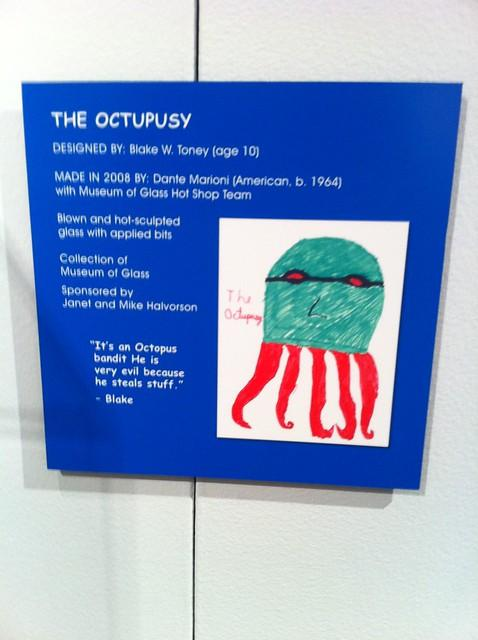

----------


100%|██████████| 49/49 [00:51<00:00,  1.05s/it]


<think>
The question_image shows a design titled "The Octupusy," created by a 10-year-old named Blake W. Toney. The design is a colorful drawing of an octopus-like figure with a green body and red tentacles, accompanied by a description of the sculpture's creation by Dante Marioni in 2008. The question_text asks to display the sculpture that follows this design, implying the user wants to see the physical representation of the artwork.

To address this, I would focus on the sculpture's visual characteristics, ensuring it aligns with the design's description. The sculpture should feature a green body and red tentacles, similar to the drawing. The final answer_image would likely show the actual glass sculpture, which matches the design's description of being "blown and hot-sculpted glass with applied bits." The sculpture would be displayed in a museum setting, as indicated by the context of the question_image.

The answer_image would depict the sculpture in a clear and well-lit environme

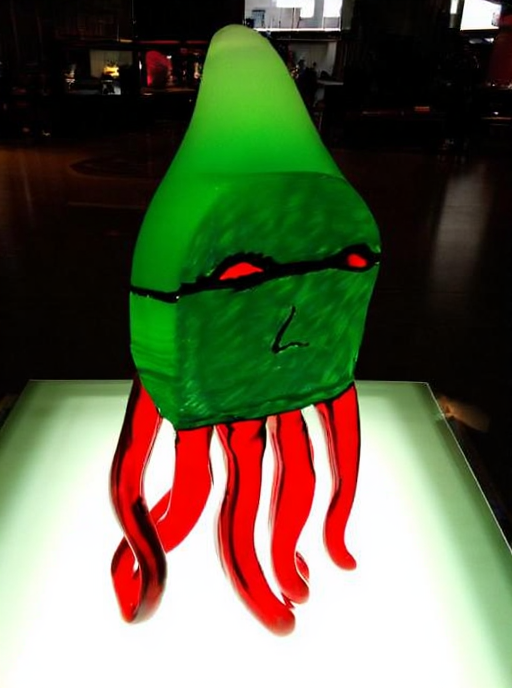

In [15]:
image = Image.open('test_images/octupusy.jpg')
prompt = 'Could you display the sculpture that takes after this design?'

display(image)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, think=True, **inference_hyper)
print(output_dict['text'])
display(output_dict['image'])

## Understanding

In [16]:
# inference_hyper=dict(
#     max_think_token_n=1000,
#     do_sample=False,
#     # text_temperature=0.3,
# )

In [17]:
# image = Image.open('test_images/meme.jpg')
# prompt = "Can someone explain what’s funny about this meme??"

# display(image)
# print(prompt)
# print('-'*10)
# output_dict = inferencer(image=image, text=prompt, understanding_output=True, **inference_hyper)
# print(output_dict['text'])